<a href="https://colab.research.google.com/github/humzkhan/Adaptive_learning/blob/main/Thesis_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install scikit-optimize

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from skopt import gp_minimize
from skopt.plots import plot_convergence

# Example black-box function (toy): we want to minimize this function
def black_box_function(x):
    """ A simple test function: f(x) = x^2 * sin(x)
        x is a list or array, but we use x[0] because it's 1D.
    """
    val = (x[0]**2) * np.sin(x[0])
    return val


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Approve the authentication prompts as needed

Mounted at /content/drive


In [8]:

# Step 2: Define the base path to your folder
import os

base_path = '/content/drive/MyDrive/Thesis_Updated/singleLayerData'
# If your Drive is mounted as "My Drive" (with a space), use:
# base_path = '/content/drive/My Drive/Thesis/Data Files/Single layer samples'

# Step 3: Recursively find all files (CSV and Excel) in the base folder
import glob
import pandas as pd

# Dictionary to store DataFrames
all_dfs = {}

# Find all CSV and Excel files
csv_files = glob.glob(os.path.join(base_path, '**', '*.csv'), recursive=True)
xls_files = glob.glob(os.path.join(base_path, '**', '*.xls'), recursive=True)
xlsx_files = glob.glob(os.path.join(base_path, '**', '*.xlsx'), recursive=True)
excel_files = xls_files + xlsx_files

print(f"Found {len(csv_files)} CSV files and {len(excel_files)} Excel files.")

# Step 4: Load all files into pandas DataFrames
# Load CSV files (skip first 14 lines of the header)
for file_path in csv_files:
    try:
        relative_path = os.path.relpath(file_path, base_path)
        print(f"Loading CSV: {relative_path} (Skipping first 14 lines)")
        df = pd.read_csv(file_path, skiprows=14)  # Skip first 14 rows
        all_dfs[relative_path] = df
    except Exception as e:
        print(f"Error reading CSV {file_path}: {e}")

# Load Excel files
for file_path in excel_files:
    try:
        relative_path = os.path.relpath(file_path, base_path)
        print(f"Loading Excel: {relative_path}")
        df = pd.read_excel(file_path)
        all_dfs[relative_path] = df
    except Exception as e:
        print(f"Error reading Excel {file_path}: {e}")

# Step 5: Verify loaded DataFrames
print("\nLoaded the following files (relative paths):")
for rel_path in all_dfs:
    print(f"  -> {rel_path}")
    print(all_dfs[rel_path].head())  # Show the first few rows for each DataFrame


Found 37 CSV files and 0 Excel files.
Loading CSV: 4%/PBT/4%-PBT-2.0mm.csv (Skipping first 14 lines)
Loading CSV: 5%/PBT/5%-PBT-2.8mm-B.csv (Skipping first 14 lines)
Loading CSV: 5%/PBT/5%-PBT-2.0mm.csv (Skipping first 14 lines)
Loading CSV: 5%/PBT/5%-PBT-2.8mm-A.csv (Skipping first 14 lines)
Loading CSV: 5%/ABS/5%-ABS-2.8mm-C.csv (Skipping first 14 lines)
Loading CSV: 5%/ABS/5%-ABS-2.8mm-B.csv (Skipping first 14 lines)
Loading CSV: 5%/ABS/5%-ABS-2.8mm-A.csv (Skipping first 14 lines)
Loading CSV: 3%/ABS/3%-ABS-1.1mm-B-ambient.csv (Skipping first 14 lines)
Loading CSV: 3%/ABS/3%-ABS-2.8mm-C.csv (Skipping first 14 lines)
Loading CSV: 3%/ABS/3%-ABS-1.1mm-A-ambient.csv (Skipping first 14 lines)
Loading CSV: 3%/ABS/3%-ABS-1.1mm-A-compressed.csv (Skipping first 14 lines)
Loading CSV: 3%/ABS/3%-ABS-1.1mm-B-compressed.csv (Skipping first 14 lines)
Loading CSV: 3%/ABS/3%-ABS-2.8mm-B.csv (Skipping first 14 lines)
Loading CSV: 3%/ABS/3%-ABS-1.1mm-B-quenched.csv (Skipping first 14 lines)
Loading C

In [9]:
def check_headers(dataframes, required_headers):
    """
    Check each DataFrame for the presence of required headers.

    Parameters:
    - dataframes (dict): Dictionary where keys are file paths and values are DataFrames.
    - required_headers (list): List of required headers to check for.

    Returns:
    - dict: Dictionary with filenames as keys and missing headers as values.
    """
    missing_headers = {}

    for file_path, df in dataframes.items():
        # Normalize the column names: lowercase and remove spaces
        normalized_columns = [col.lower().replace(" ", "") for col in df.columns]

        # Find missing headers
        file_missing = [header.lower().replace(" ", "") for header in required_headers if header.lower().replace(" ", "") not in normalized_columns]

        if file_missing:
            missing_headers[file_path] = file_missing

    return missing_headers

# Define required headers
required_headers = ['A', 'R', 'T', 'SEr', 'SEa', 'SEt']

# Check headers for all DataFrames
missing_headers_info = check_headers(all_dfs, required_headers)

# Display results
if missing_headers_info:
    print("\nFiles missing required headers:")
    for file, missing in missing_headers_info.items():
        print(f"File: {file}")
        print(f"Missing headers: {missing}")
else:
    print("\nAll files have the required headers.")



Files missing required headers:
File: 5%/ABS/5%-ABS-2.8mm-C.csv
Missing headers: ['a', 'r', 't', 'ser', 'sea', 'set']
File: 5%/ABS/5%-ABS-2.8mm-B.csv
Missing headers: ['a', 'r', 't', 'ser', 'sea', 'set']
File: 5%/ABS/5%-ABS-2.8mm-A.csv
Missing headers: ['a', 'r', 't', 'ser', 'sea', 'set']
File: 3%/ABS/3%-ABS-1.1mm-B-ambient.csv
Missing headers: ['a', 'r', 't', 'ser', 'sea', 'set']
File: 3%/ABS/3%-ABS-2.8mm-C.csv
Missing headers: ['a', 'r', 't', 'ser', 'sea', 'set']
File: 3%/ABS/3%-ABS-1.1mm-A-ambient.csv
Missing headers: ['a', 'r', 't', 'ser', 'sea', 'set']
File: 3%/ABS/3%-ABS-1.1mm-A-compressed.csv
Missing headers: ['a', 'r', 't', 'ser', 'sea', 'set']
File: 3%/ABS/3%-ABS-1.1mm-B-compressed.csv
Missing headers: ['a', 'r', 't', 'ser', 'sea', 'set']
File: 3%/ABS/3%-ABS-2.8mm-B.csv
Missing headers: ['a', 'r', 't', 'ser', 'sea', 'set']
File: 3%/ABS/3%-ABS-1.1mm-B-quenched.csv
Missing headers: ['a', 'r', 't', 'ser', 'sea', 'set']
File: 3%/ABS/3%-ABS-2.8mm-A.csv
Missing headers: ['a', 'r', 

In [10]:
import numpy as np

def add_missing_headers_flexible(dataframes):
    """
    Add missing headers to DataFrames by searching flexibly for S11 and S21 in column headers.

    Parameters:
    - dataframes (dict): Dictionary where keys are file paths and values are DataFrames.

    Returns:
    - dict: Updated dictionary of DataFrames with missing headers added.
    """
    updated_files = []  # To track files that were updated

    for file_path, df in dataframes.items():
        # Normalize column names for consistent matching
        df.columns = [col.lower().replace(" ", "").replace("(linm)", "") for col in df.columns]

        # Flag to track if any update was made
        updated = False

        # Attempt to locate 'S11' and 'S21' columns
        s11_col = next((col for col in df.columns if "s11" in col), None)
        s21_col = next((col for col in df.columns if "s21" in col), None)

        # Check and calculate each required column
        if 'r' not in df.columns:
            if s11_col:
                df['r'] = df[s11_col] ** 2
                updated = True
            else:
                print(f"Missing 'S11' column for calculating 'R' in {file_path}")
                continue

        if 't' not in df.columns:
            if s21_col:
                df['t'] = df[s21_col] ** 2
                updated = True
            else:
                print(f"Missing 'S21' column for calculating 'T' in {file_path}")
                continue

        if 'a' not in df.columns:
            if 'r' in df.columns and 't' in df.columns:
                df['a'] = 1 - df['r'] - df['t']
                updated = True
            else:
                print(f"Cannot calculate 'A' in {file_path} due to missing 'R' or 'T'")
                continue

        if 'ser' not in df.columns:
            if 'r' in df.columns:
                df['ser'] = -10 * np.log10(1 - df['r'])
                updated = True
            else:
                print(f"Cannot calculate 'SEr' in {file_path} due to missing 'R'")
                continue

        if 'set' not in df.columns:
            if 't' in df.columns:
                df['set'] = -10 * np.log10(df['t'])
                updated = True
            else:
                print(f"Cannot calculate 'SEt' in {file_path} due to missing 'T'")
                continue

        if 'sea' not in df.columns:
            if 'set' in df.columns and 'ser' in df.columns:
                df['sea'] = df['set'] - df['ser']
                updated = True
            else:
                print(f"Cannot calculate 'SEa' in {file_path} due to missing 'SEt' or 'SEr'")
                continue

        # If updated, track the file
        if updated:
            updated_files.append(file_path)

        # Update DataFrame in the dictionary
        dataframes[file_path] = df

    # Print updated files
    for file_path in updated_files:
        print(f"\nUpdated {file_path}:")
        print(dataframes[file_path].head(1))  # Print only the first row for preview

    return dataframes

# Apply the updated function to all DataFrames
updated_dfs = add_missing_headers_flexible(all_dfs)



Updated 5%/ABS/5%-ABS-2.8mm-C.csv:
   frequency(hz)   tr2s11    tr3s21  tr1data(e')  tr4data(e'')  tr5data(u')  \
0   1.240000e+10  0.87814  0.042179     6.811813      2.641842          1.0   

   tr6data(u'')         r         t        a       ser        set        sea  
0           0.0  0.771131  0.001779  0.22709  6.404125  27.498031  21.093906  

Updated 5%/ABS/5%-ABS-2.8mm-B.csv:
   frequency(hz)    tr2s11    tr3s21  tr1data(e')  tr4data(e'')  tr5data(u')  \
0   1.240000e+10  0.845358  0.052452     6.828651       3.05671          1.0   

   tr6data(u'')        r         t         a       ser        set        sea  
0           0.0  0.71463  0.002751  0.282618  5.445922  25.604749  20.158827  

Updated 5%/ABS/5%-ABS-2.8mm-A.csv:
   frequency(hz)    tr2s11    tr3s21  tr1data(e')  tr4data(e'')  tr5data(u')  \
0   1.240000e+10  0.856208  0.037372     6.844234      2.925287          1.0   

   tr6data(u'')         r         t         a       ser       set        sea  
0           0.0 

In [11]:
import pandas as pd

def standardize_files(dataframes):
    """
    Standardize the headers and clean up the data for all provided dataframes.

    Parameters:
    - dataframes (dict): Dictionary where keys are file paths and values are DataFrames.

    Returns:
    - dict: Updated dictionary with standardized DataFrames.
    """
    standardized_headers = [
        "frequency(Hz)", "Tr 1  Data(e')", "Tr 2  Data(e'')", "Tr 3  Data(u')",
        "Tr 4  Data(u'')", "Tr 5  S11(LinM)", "Tr 6  S21(LinM)", "R", "T", "A", "SEr", "Sea", "Set"
    ]
    standardized_dfs = {}

    for file_path, df in dataframes.items():
        # Standardize column names (remove spacing, normalize to lowercase for matching)
        df.columns = [col.lower().strip().replace(" ", "").replace("(linm)", "") for col in df.columns]

        # Map the standardized headers to the current column names
        column_mapping = {}
        for std_col in standardized_headers:
            std_col_lower = std_col.lower().replace(" ", "").replace("(linm)", "")
            match = next((col for col in df.columns if col == std_col_lower), None)
            if match:
                column_mapping[match] = std_col

        # Apply the mapping to the DataFrame
        df = df.rename(columns=column_mapping)

        # Retain only the standardized headers
        df = df[[col for col in standardized_headers if col in df.columns]]

        # Filter rows to keep only frequency values within the specified range (12.4 GHz to 18 GHz)
        freq_col = "frequency(Hz)"
        if freq_col in df.columns:
            df = df[(df[freq_col] >= 12.4e9) & (df[freq_col] <= 18e9)]

        # Save the standardized DataFrame
        standardized_dfs[file_path] = df

    return standardized_dfs


# Apply the standardization function to the dataframes
standardized_dfs = standardize_files(all_dfs)

# Check the results for a few files
for file_path, df in standardized_dfs.items():
    print(f"\nStandardized {file_path}:")
    #print(df.head())



Standardized 4%/PBT/4%-PBT-2.0mm.csv:

Standardized 5%/PBT/5%-PBT-2.8mm-B.csv:

Standardized 5%/PBT/5%-PBT-2.0mm.csv:

Standardized 5%/PBT/5%-PBT-2.8mm-A.csv:

Standardized 5%/ABS/5%-ABS-2.8mm-C.csv:

Standardized 5%/ABS/5%-ABS-2.8mm-B.csv:

Standardized 5%/ABS/5%-ABS-2.8mm-A.csv:

Standardized 3%/ABS/3%-ABS-1.1mm-B-ambient.csv:

Standardized 3%/ABS/3%-ABS-2.8mm-C.csv:

Standardized 3%/ABS/3%-ABS-1.1mm-A-ambient.csv:

Standardized 3%/ABS/3%-ABS-1.1mm-A-compressed.csv:

Standardized 3%/ABS/3%-ABS-1.1mm-B-compressed.csv:

Standardized 3%/ABS/3%-ABS-2.8mm-B.csv:

Standardized 3%/ABS/3%-ABS-1.1mm-B-quenched.csv:

Standardized 3%/ABS/3%-ABS-2.8mm-A.csv:

Standardized 3%/ABS/3%-ABS-1.1mm-A-quenched.csv:

Standardized 3%/PBT/3%-PBT-2.8mm-A.csv:

Standardized 3%/PBT/3%-PBT-2.8mm-B.csv:

Standardized 3%/PBT/3%-PBT-2.0mm.csv:

Standardized 1%/ABS/1%-ABS-2.8mm-C.csv:

Standardized 1%/ABS/1%-ABS-2.8mm-A.csv:

Standardized 1%/ABS/1%-ABS-2.8mm-B.csv:

Standardized 1%/PBT/1%-PBT-1.0mm.csv:

Standard

In [12]:
def remove_footer_data(dataframes):
    """
    Remove footer data from DataFrames by splitting off rows starting at the first null value.

    Parameters:
    - dataframes (dict): Dictionary where keys are file paths and values are DataFrames.

    Returns:
    - dict: Updated dictionary of DataFrames with footer data removed.
    """
    updated_dataframes = {}

    for file_path, df in dataframes.items():
        # Find the first index where a null value appears
        null_index = df.isnull().any(axis=1).idxmax() if df.isnull().any().any() else None

        if null_index is not None and null_index > 0:
            # Keep only the rows before the first null
            df_cleaned = df.iloc[:null_index]
            print(f"Footer data removed from {file_path} starting at index {null_index}")
        else:
            df_cleaned = df  # No null values, keep the DataFrame as is
            print(f"No footer data found in {file_path}")

        # Update the dictionary with cleaned DataFrame
        updated_dataframes[file_path] = df_cleaned

    return updated_dataframes

# Apply the function to remove footer data
cleaned_dfs = remove_footer_data(standardized_dfs)


No footer data found in 4%/PBT/4%-PBT-2.0mm.csv
No footer data found in 5%/PBT/5%-PBT-2.8mm-B.csv
No footer data found in 5%/PBT/5%-PBT-2.0mm.csv
No footer data found in 5%/PBT/5%-PBT-2.8mm-A.csv
No footer data found in 5%/ABS/5%-ABS-2.8mm-C.csv
No footer data found in 5%/ABS/5%-ABS-2.8mm-B.csv
No footer data found in 5%/ABS/5%-ABS-2.8mm-A.csv
No footer data found in 3%/ABS/3%-ABS-1.1mm-B-ambient.csv
No footer data found in 3%/ABS/3%-ABS-2.8mm-C.csv
No footer data found in 3%/ABS/3%-ABS-1.1mm-A-ambient.csv
No footer data found in 3%/ABS/3%-ABS-1.1mm-A-compressed.csv
No footer data found in 3%/ABS/3%-ABS-1.1mm-B-compressed.csv
No footer data found in 3%/ABS/3%-ABS-2.8mm-B.csv
No footer data found in 3%/ABS/3%-ABS-1.1mm-B-quenched.csv
No footer data found in 3%/ABS/3%-ABS-2.8mm-A.csv
No footer data found in 3%/ABS/3%-ABS-1.1mm-A-quenched.csv
No footer data found in 3%/PBT/3%-PBT-2.8mm-A.csv
No footer data found in 3%/PBT/3%-PBT-2.8mm-B.csv
No footer data found in 3%/PBT/3%-PBT-2.0mm.csv


In [13]:
def inspect_footer(dataframes, n=5):
    """
    Inspect the bottom rows of each DataFrame to check for footer data.

    Parameters:
    - dataframes (dict): Dictionary where keys are file paths and values are DataFrames.
    - n (int): Number of bottom rows to display from each DataFrame.

    Returns:
    - None: Prints the bottom rows of each DataFrame.
    """
    for file_path, df in dataframes.items():
        print(f"\nBottom {n} rows of {file_path}:")
        print(df.tail(n))

# Inspect the bottom rows of the standardized DataFrames
inspect_footer(cleaned_dfs, n=5)



Bottom 5 rows of 4%/PBT/4%-PBT-2.0mm.csv:
    frequency(Hz)      R      T      A    SEr     Sea     Set
95   1.777374e+10  0.646  0.002  0.352  4.513  23.638  28.151
96   1.783030e+10  0.637  0.002  0.361  4.406  23.805  28.212
97   1.788687e+10  0.638  0.002  0.361  4.408  23.824  28.232
98   1.794343e+10  0.640  0.001  0.359  4.436  23.804  28.239
99   1.800000e+10  0.633  0.001  0.366  4.351  23.939  28.291

Bottom 5 rows of 5%/PBT/5%-PBT-2.8mm-B.csv:
    frequency(Hz)  Tr 1  Data(e')  Tr 2  Data(e'')  Tr 3  Data(u')  \
95   1.777374e+10            81.8             71.1            2.11   
96   1.783030e+10            79.7             73.3            2.08   
97   1.788687e+10            82.4             71.4            2.07   
98   1.794343e+10            78.8             74.0            2.05   
99   1.800000e+10            80.3             71.0            2.08   

    Tr 4  Data(u'')  Tr 5  S11(LinM) Tr 6  S21(LinM)      R      T      A  \
95           -0.803            0.819      

In [14]:
def inspect_cleaned_dfs(dataframes):
    """
    Inspect the structure and contents of the cleaned_dfs dictionary.

    Parameters:
    - dataframes (dict): Dictionary of cleaned DataFrames.

    Returns:
    - None: Prints summary information about each DataFrame.
    """
    print(f"Total DataFrames: {len(dataframes)}")
    for file_path, df in dataframes.items():
        print("\n---")
        print(f"File Path: {file_path}")
        print(f"DataFrame Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"First Few Rows:\n{df.head()}")
        print(f"Null Values:\n{df.isnull().sum()}")
        print(f"Column Types:\n{df.dtypes}")
        print("---")

# Inspect the cleaned_dfs dictionary
inspect_cleaned_dfs(cleaned_dfs)


Total DataFrames: 37

---
File Path: 4%/PBT/4%-PBT-2.0mm.csv
DataFrame Shape: (100, 7)
Columns: ['frequency(Hz)', 'R', 'T', 'A', 'SEr', 'Sea', 'Set']
First Few Rows:
   frequency(Hz)      R      T      A    SEr     Sea     Set
0   1.240000e+10  0.752  0.002  0.246  6.058  20.823  26.881
1   1.245657e+10  0.747  0.002  0.251  5.974  20.900  26.875
2   1.251313e+10  0.748  0.002  0.250  5.990  20.896  26.886
3   1.256970e+10  0.749  0.002  0.249  6.011  20.861  26.872
4   1.262626e+10  0.745  0.002  0.253  5.928  20.959  26.887
Null Values:
frequency(Hz)    0
R                0
T                0
A                0
SEr              0
Sea              0
Set              0
dtype: int64
Column Types:
frequency(Hz)    float64
R                float64
T                float64
A                float64
SEr              float64
Sea              float64
Set              float64
dtype: object
---

---
File Path: 5%/PBT/5%-PBT-2.8mm-B.csv
DataFrame Shape: (100, 13)
Columns: ['frequency(Hz)', "Tr 1 

In [15]:
import pandas as pd
import numpy as np

def create_thesis_dataframe(dataframes):
    """
    Create a single thesis dataframe by processing multiple dataframes.

    Parameters:
    - dataframes (dict): Dictionary where keys are file paths and values are DataFrames.

    Returns:
    - pd.DataFrame: Thesis dataframe with all rows appended.
    """
    thesis_data = []  # List to store rows for the thesis dataframe

    for file_path, df in dataframes.items():
        # Call the thesis_row function for each dataframe
        thesis_row_data = thesis_row(file_path, df)
        if thesis_row_data:  # Only append if the row is successfully created
            thesis_data.append(thesis_row_data)

    # Convert the list of rows into a DataFrame
    thesis_df = pd.DataFrame(thesis_data)
    return thesis_df

def thesis_row(file_path, df):
    """
    Extract features for a single dataframe and return as a dictionary (row).

    Parameters:
    - file_path (str): Path to the file.
    - df (pd.DataFrame): Dataframe to process.

    Returns:
    - dict: Extracted features as a dictionary.
    """
    # Extract file properties
    import re
    match = re.search(r'(\d+)%/(ABS|PBT)/(\d+)%-(ABS|PBT)-([\d.]+)mm', file_path)
    if not match:
        print(f"Filename format not recognized: {file_path}")
        return None

    cnt_pct = int(match.group(1))
    material = match.group(2)
    thickness = float(match.group(5))

    # Normalize column names
    df.columns = [col.strip().lower() for col in df.columns]

    # Create a row with features
    row = {
        'filename': file_path,
        'cnt_pct': cnt_pct,
        'material': material,
        'thickness': thickness,
        'mean_a': df['a'].mean() if 'a' in df.columns else np.nan,
        'max_a': df['a'].max() if 'a' in df.columns else np.nan,
        'skew_a': df['a'].skew() if 'a' in df.columns else np.nan,
        'kurt_a': df['a'].kurt() if 'a' in df.columns else np.nan,
        'mean_r': df['r'].mean() if 'r' in df.columns else np.nan,
        'mean_t': df['t'].mean() if 't' in df.columns else np.nan,
        '%_a90': (df['a'] >= 0.9).mean() * 100 if 'a' in df.columns else np.nan,
        'f_start_a90': df.loc[df['a'] >= 0.9, 'frequency(hz)'].min() if 'a' in df.columns and not df.loc[df['a'] >= 0.9].empty else np.nan,
        'f_end_a90': df.loc[df['a'] >= 0.9, 'frequency(hz)'].max() if 'a' in df.columns and not df.loc[df['a'] >= 0.9].empty else np.nan,
        'bw_a90': df.loc[df['a'] >= 0.9, 'frequency(hz)'].max() - df.loc[df['a'] >= 0.9, 'frequency(hz)'].min()
        if 'a' in df.columns and not df.loc[df['a'] >= 0.9].empty else np.nan,
        '%_r10': (df['r'] < 0.1).mean() * 100 if 'r' in df.columns else np.nan,
        'f_start_r10': df.loc[df['r'] < 0.1, 'frequency(hz)'].min() if 'r' in df.columns and not df.loc[df['r'] < 0.1].empty else np.nan,
        'f_end_r10': df.loc[df['r'] < 0.1, 'frequency(hz)'].max() if 'r' in df.columns and not df.loc[df['r'] < 0.1].empty else np.nan,
        '%_t2': (df['t'] < 0.02).mean() * 100 if 't' in df.columns else np.nan,
        'f_start_t2': df.loc[df['t'] < 0.02, 'frequency(hz)'].min() if 't' in df.columns and not df.loc[df['t'] < 0.02].empty else np.nan,
        'f_end_t2': df.loc[df['t'] < 0.02, 'frequency(hz)'].max() if 't' in df.columns and not df.loc[df['t'] < 0.02].empty else np.nan,
    }
    return row

# Example usage:
thesis_df = create_thesis_dataframe(cleaned_dfs)

# Save or inspect the dataframe
print(thesis_df)
# Optionally save it to a file:
# thesis_df.to_csv("thesis_data.csv", index=False)


                                filename  cnt_pct material  thickness  \
0                4%/PBT/4%-PBT-2.0mm.csv        4      PBT        2.0   
1              5%/PBT/5%-PBT-2.8mm-B.csv        5      PBT        2.8   
2                5%/PBT/5%-PBT-2.0mm.csv        5      PBT        2.0   
3              5%/PBT/5%-PBT-2.8mm-A.csv        5      PBT        2.8   
4              5%/ABS/5%-ABS-2.8mm-C.csv        5      ABS        2.8   
5              5%/ABS/5%-ABS-2.8mm-B.csv        5      ABS        2.8   
6              5%/ABS/5%-ABS-2.8mm-A.csv        5      ABS        2.8   
7      3%/ABS/3%-ABS-1.1mm-B-ambient.csv        3      ABS        1.1   
8              3%/ABS/3%-ABS-2.8mm-C.csv        3      ABS        2.8   
9      3%/ABS/3%-ABS-1.1mm-A-ambient.csv        3      ABS        1.1   
10  3%/ABS/3%-ABS-1.1mm-A-compressed.csv        3      ABS        1.1   
11  3%/ABS/3%-ABS-1.1mm-B-compressed.csv        3      ABS        1.1   
12             3%/ABS/3%-ABS-2.8mm-B.csv        3  

In [16]:
def thesis_row_with_alternative_features(file_path, df):
    """
    Extract features for a single dataframe with alternative features for modeling.

    Parameters:
    - file_path (str): Path to the file.
    - df (pd.DataFrame): Dataframe to process.

    Returns:
    - dict: Extracted features as a dictionary.
    """
    import re
    match = re.search(r'(\d+)%/(ABS|PBT)/(\d+)%-(ABS|PBT)-([\d.]+)mm', file_path)
    if not match:
        print(f"Filename format not recognized: {file_path}")
        return None

    cnt_pct = int(match.group(1))
    material = match.group(2)
    thickness = float(match.group(5))

    # Normalize column names
    df.columns = [col.strip().lower() for col in df.columns]

    # Create a row with features
    row = {
        'filename': file_path,
        'cnt_pct': cnt_pct,
        'material': material,
        'thickness': thickness,
        'mean_a': df['a'].mean() if 'a' in df.columns else np.nan,
        'max_a': df['a'].max() if 'a' in df.columns else np.nan,
        'std_a': df['a'].std() if 'a' in df.columns else np.nan,
        'range_a': (df['a'].max() - df['a'].min()) if 'a' in df.columns else np.nan,
        'weighted_mean_a': (df['a'] * df['frequency(hz)']).sum() / df['frequency(hz)'].sum()
        if 'a' in df.columns else np.nan,
        'mean_r': df['r'].mean() if 'r' in df.columns else np.nan,
        'std_r': df['r'].std() if 'r' in df.columns else np.nan,
        'mean_t': df['t'].mean() if 't' in df.columns else np.nan,
        'std_t': df['t'].std() if 't' in df.columns else np.nan,
        'mean_a_to_r_ratio': (df['a'].mean() / df['r'].mean()) if 'a' in df.columns and 'r' in df.columns else np.nan,
        'gradient_a': np.gradient(df['a']).mean() if 'a' in df.columns else np.nan,
        'gradient_r': np.gradient(df['r']).mean() if 'r' in df.columns else np.nan,
        'gradient_t': np.gradient(df['t']).mean() if 't' in df.columns else np.nan,
        'performance_score': (
            0.5 * df['a'].mean() - 0.3 * df['r'].mean() + 0.2 * df['t'].mean()
        ) if 'a' in df.columns and 'r' in df.columns and 't' in df.columns else np.nan,
    }
    return row

def create_thesis_dataframe_with_alternative_features(dataframes):
    """
    Create a single thesis dataframe by processing multiple dataframes with alternative features.

    Parameters:
    - dataframes (dict): Dictionary where keys are file paths and values are DataFrames.

    Returns:
    - pd.DataFrame: Thesis dataframe with all rows appended.
    """
    thesis_data = []
    for file_path, df in dataframes.items():
        thesis_row_data = thesis_row_with_alternative_features(file_path, df)
        if thesis_row_data:
            thesis_data.append(thesis_row_data)

    return pd.DataFrame(thesis_data)

# Example usage:
thesis_df = create_thesis_dataframe_with_alternative_features(cleaned_dfs)

# Inspect the updated dataframe
print(thesis_df)


                                filename  cnt_pct material  thickness  \
0                4%/PBT/4%-PBT-2.0mm.csv        4      PBT        2.0   
1              5%/PBT/5%-PBT-2.8mm-B.csv        5      PBT        2.8   
2                5%/PBT/5%-PBT-2.0mm.csv        5      PBT        2.0   
3              5%/PBT/5%-PBT-2.8mm-A.csv        5      PBT        2.8   
4              5%/ABS/5%-ABS-2.8mm-C.csv        5      ABS        2.8   
5              5%/ABS/5%-ABS-2.8mm-B.csv        5      ABS        2.8   
6              5%/ABS/5%-ABS-2.8mm-A.csv        5      ABS        2.8   
7      3%/ABS/3%-ABS-1.1mm-B-ambient.csv        3      ABS        1.1   
8              3%/ABS/3%-ABS-2.8mm-C.csv        3      ABS        2.8   
9      3%/ABS/3%-ABS-1.1mm-A-ambient.csv        3      ABS        1.1   
10  3%/ABS/3%-ABS-1.1mm-A-compressed.csv        3      ABS        1.1   
11  3%/ABS/3%-ABS-1.1mm-B-compressed.csv        3      ABS        1.1   
12             3%/ABS/3%-ABS-2.8mm-B.csv        3  

Visualizations

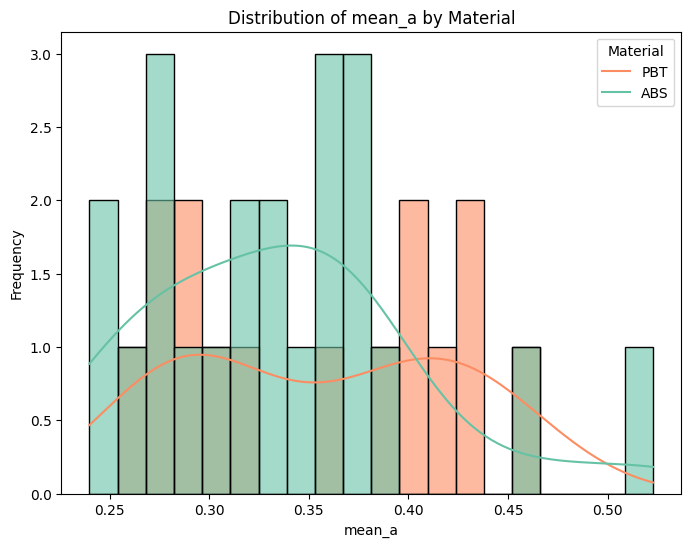

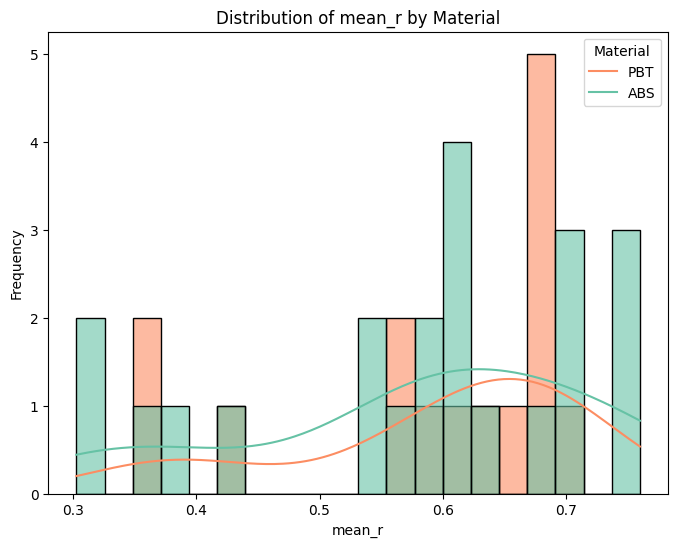

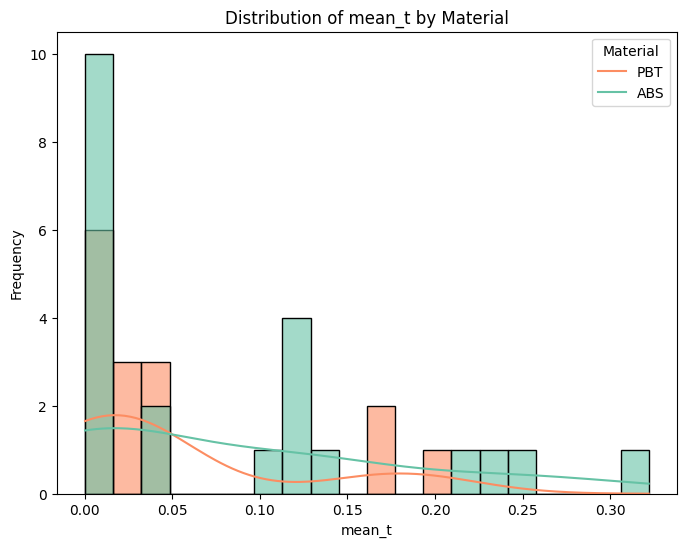

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in ['mean_a', 'mean_r', 'mean_t']:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=thesis_df, x=feature, hue='material', kde=True, bins=20, palette='Set2', alpha=0.6)
    plt.title(f'Distribution of {feature} by Material')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend(title='Material', labels=['PBT', 'ABS'])
    plt.show()


<ipython-input-18-e3c17c7718f1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=thesis_df, x='material', y=feature, palette='Set3')


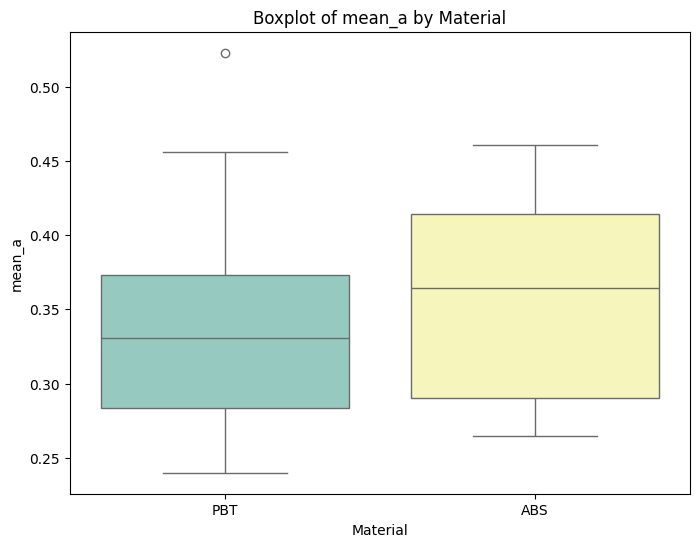

<ipython-input-18-e3c17c7718f1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=thesis_df, x='material', y=feature, palette='Set3')


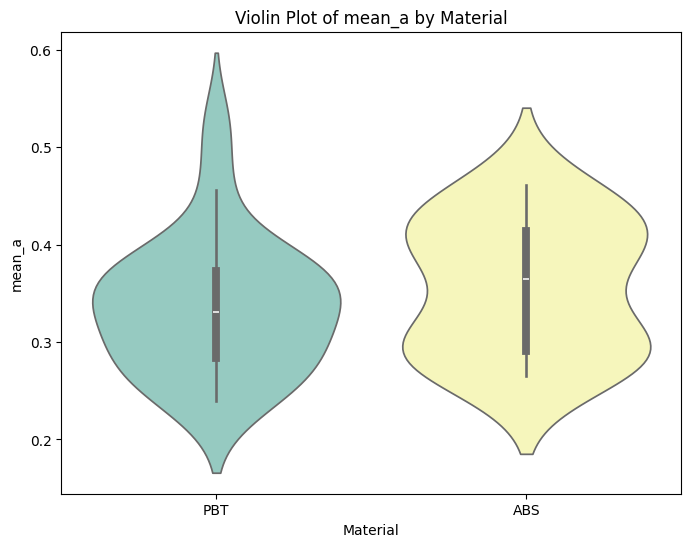

<ipython-input-18-e3c17c7718f1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=thesis_df, x='material', y=feature, palette='Set3')


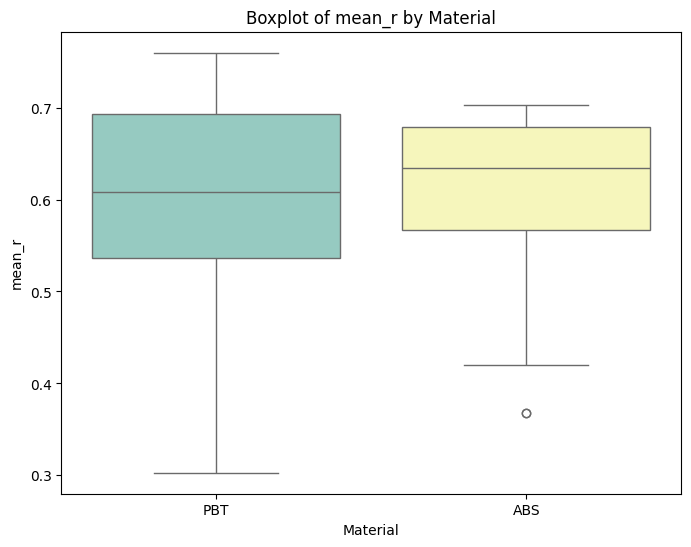

<ipython-input-18-e3c17c7718f1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=thesis_df, x='material', y=feature, palette='Set3')


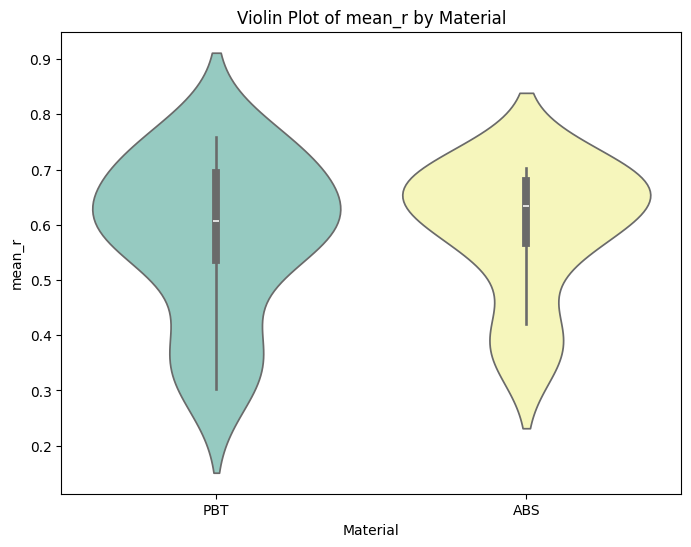

<ipython-input-18-e3c17c7718f1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=thesis_df, x='material', y=feature, palette='Set3')


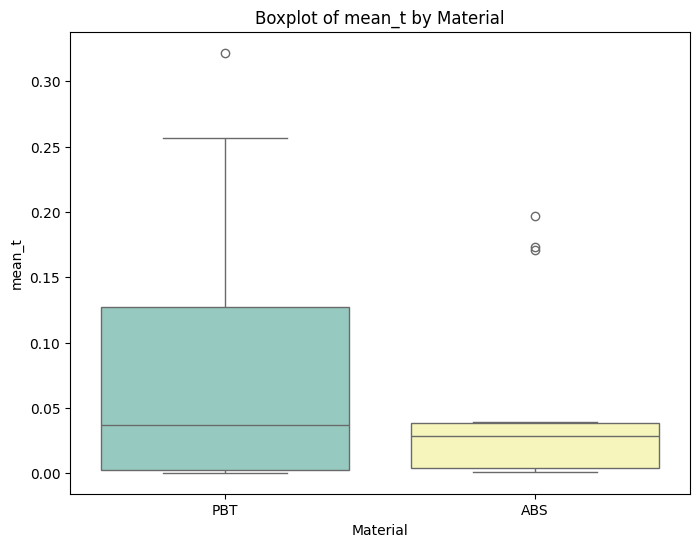

<ipython-input-18-e3c17c7718f1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=thesis_df, x='material', y=feature, palette='Set3')


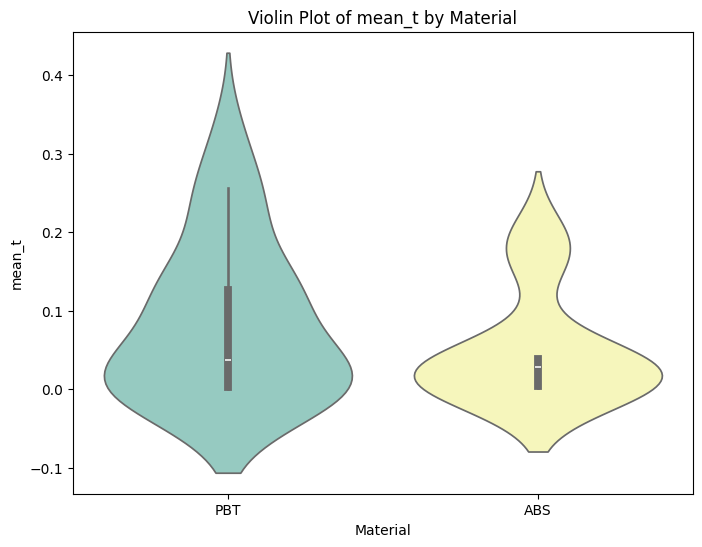

In [18]:
for feature in ['mean_a', 'mean_r', 'mean_t']:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=thesis_df, x='material', y=feature, palette='Set3')
    plt.title(f'Boxplot of {feature} by Material')
    plt.xlabel('Material')
    plt.ylabel(feature)
    plt.show()

    # Violin plot for more detail
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=thesis_df, x='material', y=feature, palette='Set3')
    plt.title(f'Violin Plot of {feature} by Material')
    plt.xlabel('Material')
    plt.ylabel(feature)
    plt.show()


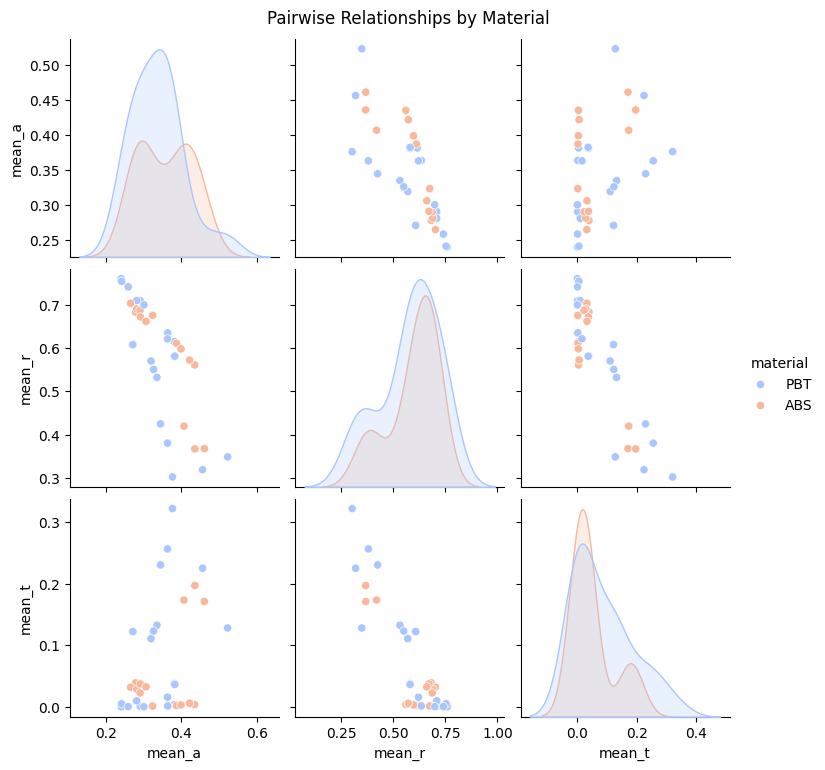

In [19]:
sns.pairplot(thesis_df, vars=['mean_a', 'mean_r', 'mean_t'], hue='material', palette='coolwarm', diag_kind='kde')
plt.suptitle('Pairwise Relationships by Material', y=1.02)
plt.show()


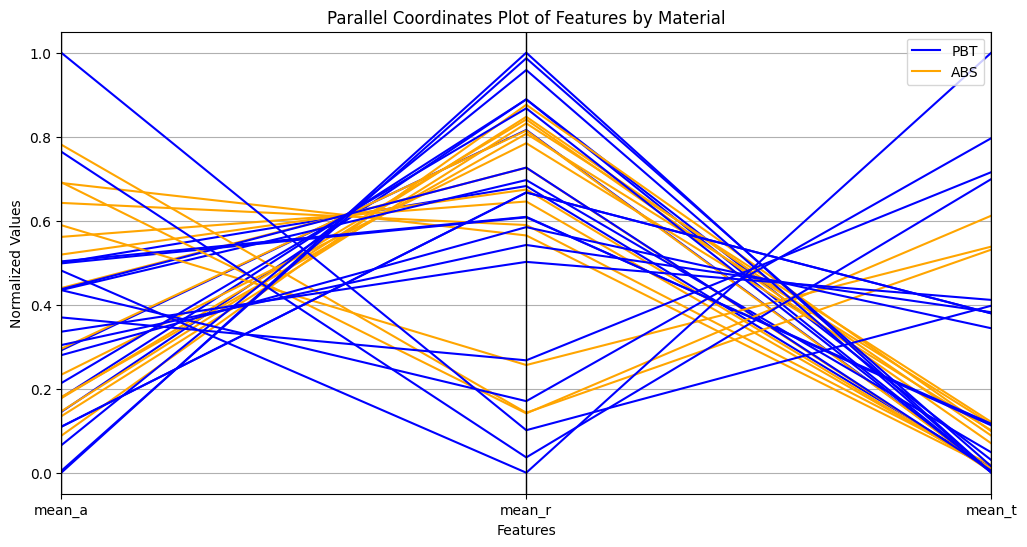

In [20]:
from pandas.plotting import parallel_coordinates

# Normalize features for better comparison
normalized_df = thesis_df.copy()
for col in ['mean_a', 'mean_r', 'mean_t']:
    normalized_df[col] = (normalized_df[col] - normalized_df[col].min()) / (normalized_df[col].max() - normalized_df[col].min())

plt.figure(figsize=(12, 6))
parallel_coordinates(normalized_df, class_column='material', cols=['mean_a', 'mean_r', 'mean_t'], color=['blue', 'orange'])
plt.title('Parallel Coordinates Plot of Features by Material')
plt.xlabel('Features')
plt.ylabel('Normalized Values')
plt.show()


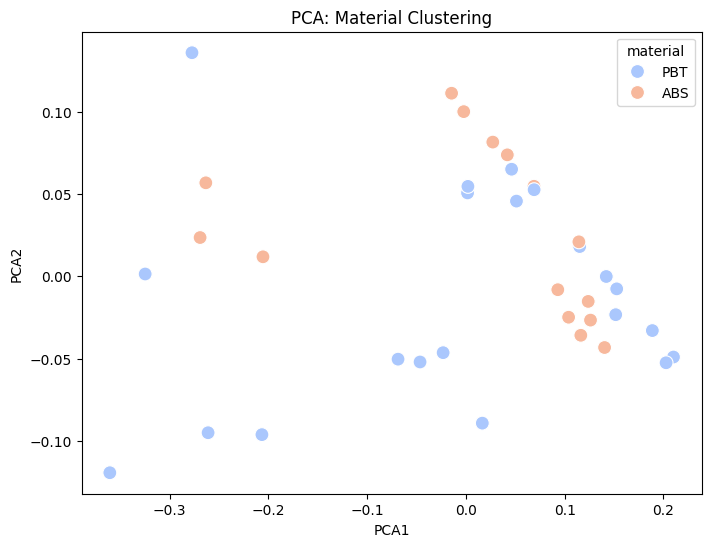

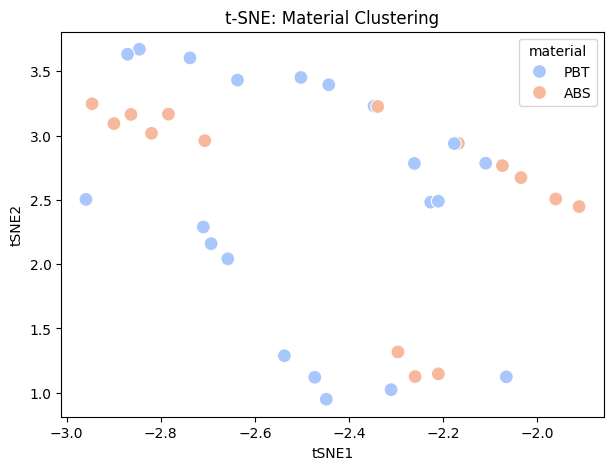

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Select numeric columns for dimensionality reduction
numeric_cols = ['mean_a', 'mean_r', 'mean_t', 'std_a', 'std_r', 'std_t']
data = thesis_df[numeric_cols].dropna()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)
thesis_df['PCA1'], thesis_df['PCA2'] = pca_result[:, 0], pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=thesis_df, x='PCA1', y='PCA2', hue='material', palette='coolwarm', s=100)
plt.title('PCA: Material Clustering')
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data)
thesis_df['tSNE1'], thesis_df['tSNE2'] = tsne_result[:, 0], tsne_result[:, 1]

plt.figure(figsize=(7,5))
sns.scatterplot(data=thesis_df, x='tSNE1', y='tSNE2', hue='material', palette='coolwarm', s=100)
plt.title('t-SNE: Material Clustering')
plt.show()


ABS modalities

In [22]:
# Create subsets
quenched_compressed_ambient_files = [
    '3%-ABS-1.1mm-B-quenched',
    '3%-ABS-1.1mm-B-compressed',
    '3%-ABS-1.1mm-B-ambient',
    '3%-ABS-1.1mm-A-quenched',
    '3%-ABS-1.1mm-A-compressed',
    '3%-ABS-1.1mm-A-ambient'
]

abs_quenched_compressed = thesis_df[thesis_df['filename'].str.contains('|'.join(quenched_compressed_ambient_files))]
abs_other = thesis_df[(thesis_df['material'] == 'ABS') & (~thesis_df['filename'].str.contains('|'.join(quenched_compressed_ambient_files)))]


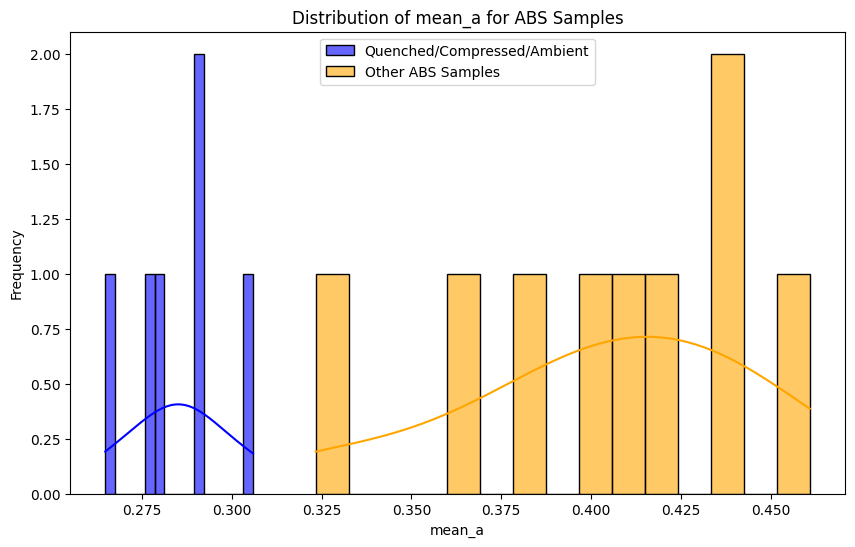

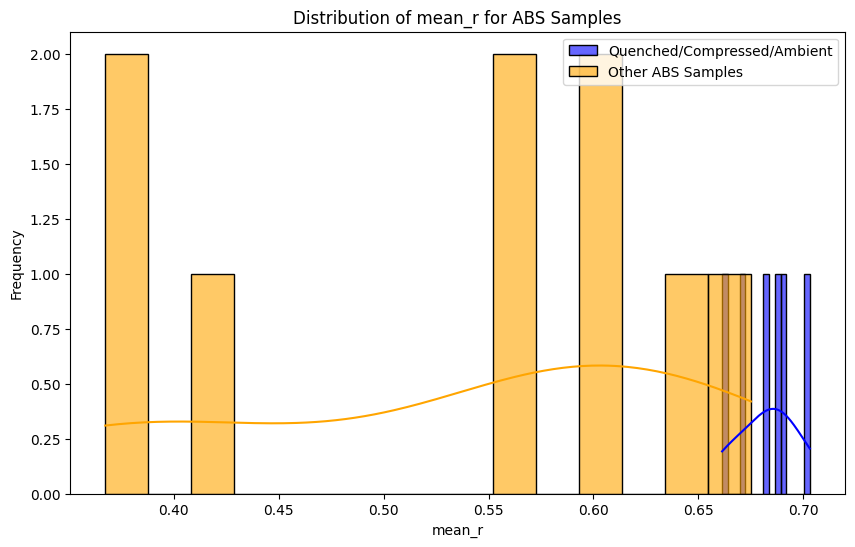

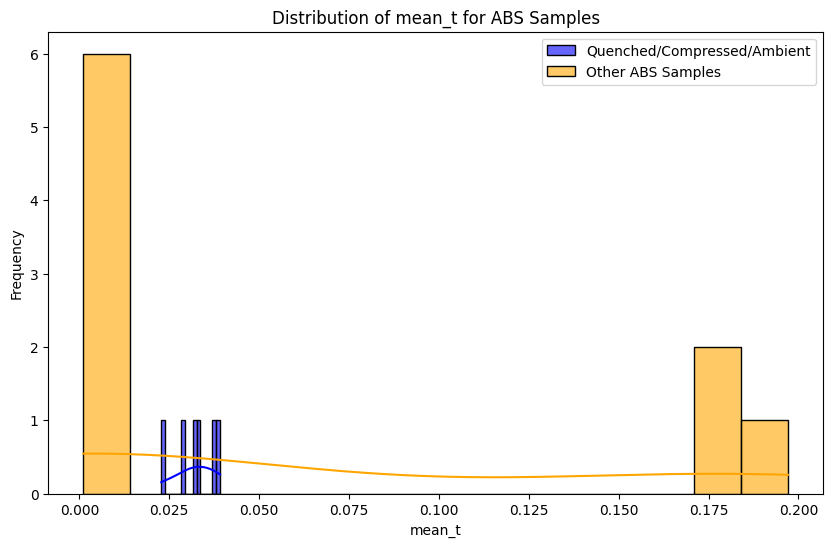

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histograms_with_kde(feature):
    plt.figure(figsize=(10, 6))
    sns.histplot(abs_quenched_compressed[feature], kde=True, color='blue', label='Quenched/Compressed/Ambient', bins=15, alpha=0.6)
    sns.histplot(abs_other[feature], kde=True, color='orange', label='Other ABS Samples', bins=15, alpha=0.6)
    plt.title(f'Distribution of {feature} for ABS Samples')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot distributions
for feature in ['mean_a', 'mean_r', 'mean_t']:
    plot_histograms_with_kde(feature)


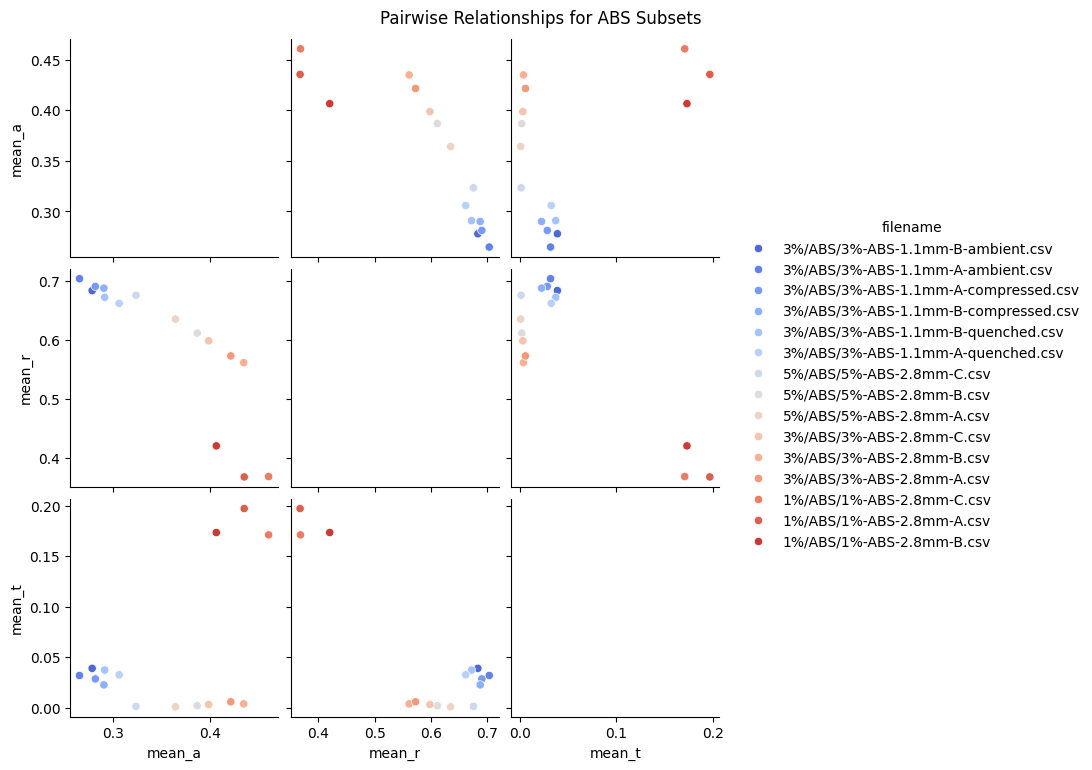

In [24]:
sns.pairplot(
    pd.concat([abs_quenched_compressed, abs_other]),
    vars=['mean_a', 'mean_r', 'mean_t'],
    hue='filename',
    palette='coolwarm',
    diag_kind='kde'
)
plt.suptitle('Pairwise Relationships for ABS Subsets', y=1.02)
plt.show()


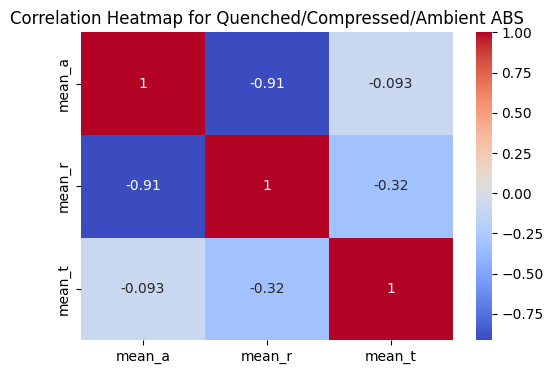

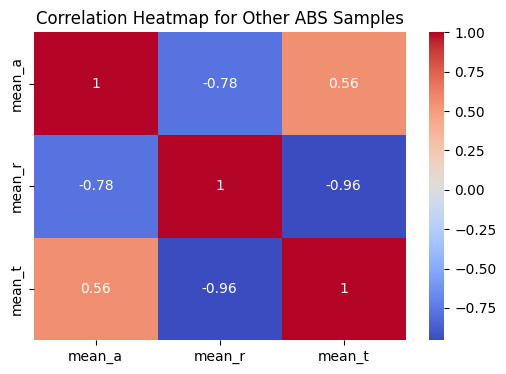

In [25]:
for subset, name in [(abs_quenched_compressed, 'Quenched/Compressed/Ambient ABS'), (abs_other, 'Other ABS Samples')]:
    corr_matrix = subset[['mean_a', 'mean_r', 'mean_t']].corr()
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True)
    plt.title(f'Correlation Heatmap for {name}')
    plt.show()


Modelling

In [26]:
thesis_df.head()

filename  cnt_pct material  thickness    mean_a     max_a  \
0    4%/PBT/4%-PBT-2.0mm.csv        4      PBT        2.0  0.322400  0.366000   
1  5%/PBT/5%-PBT-2.8mm-B.csv        5      PBT        2.8  0.290490  0.340000   
2    5%/PBT/5%-PBT-2.0mm.csv        5      PBT        2.0  0.280870  0.308000   
3  5%/PBT/5%-PBT-2.8mm-A.csv        5      PBT        2.8  0.381270  0.428000   
4  5%/ABS/5%-ABS-2.8mm-C.csv        5      ABS        2.8  0.323394  0.378991   

      std_a   range_a  weighted_mean_a    mean_r  ...         std_t  \
0  0.032448  0.120000         0.325429  0.675710  ...  1.407053e-04   
1  0.031941  0.109000         0.293846  0.708940  ...  6.537985e-19   
2  0.024239  0.087000         0.282945  0.709060  ...  8.932406e-04   
3  0.032487  0.121000         0.384122  0.614710  ...  2.615194e-18   
4  0.037225  0.151901         0.327121  0.675066  ...  1.515093e-04   

   mean_a_to_r_ratio  gradient_a  gradient_r  gradient_t  performance_score  \
0           0.477128    0.001260   -0.001250   -0.000010          -0.041117   
1           0.409753    0.001065   -0.001055    0.000000          -0.067237   
2           0.396116    0.000950   -0.000915   -0.000030          -0.070281   
3           0.620244    0.001225   -0.001235    0.000000           0.007022   
4           0.479055    0.001591   -0.001586   -0.000005          -0.040515   

       PCA1      PCA2     tSNE1     tSNE2  
0  0.115240  0.018058 -2.347158  3.230204  
1  0.152722 -0.007661 -2.502394  3.452564  
2  0.151723 -0.023353 -2.637094  3.431880  
3  0.046279  0.065039 -2.109944  2.785143  
4  0.114426  0.020920 -2.339236  3.226514  

[5 rows x 22 columns]

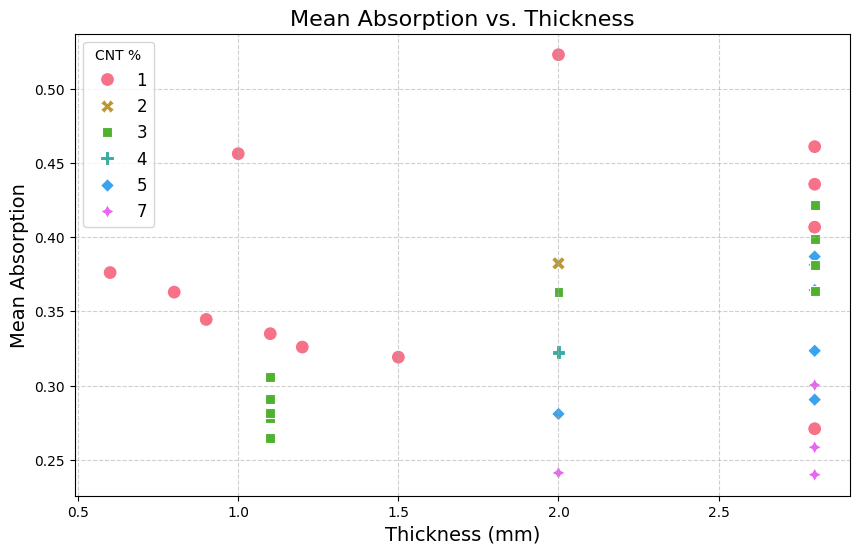

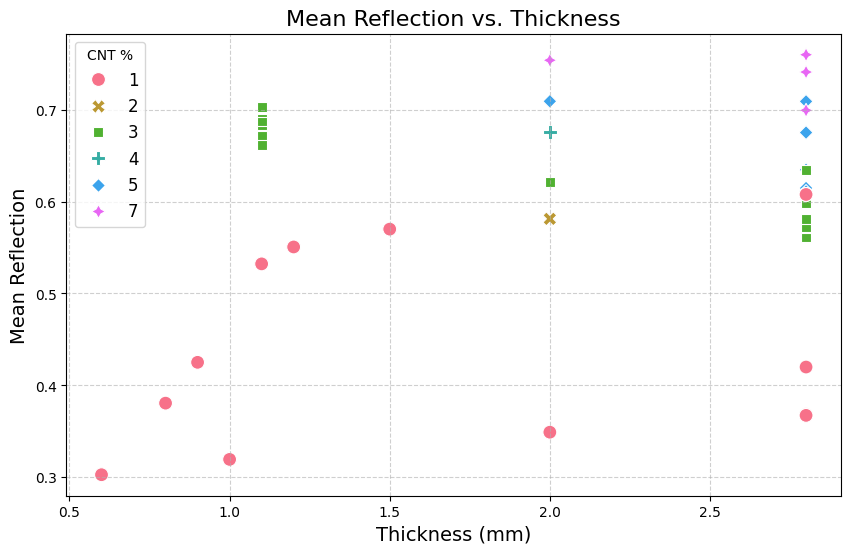

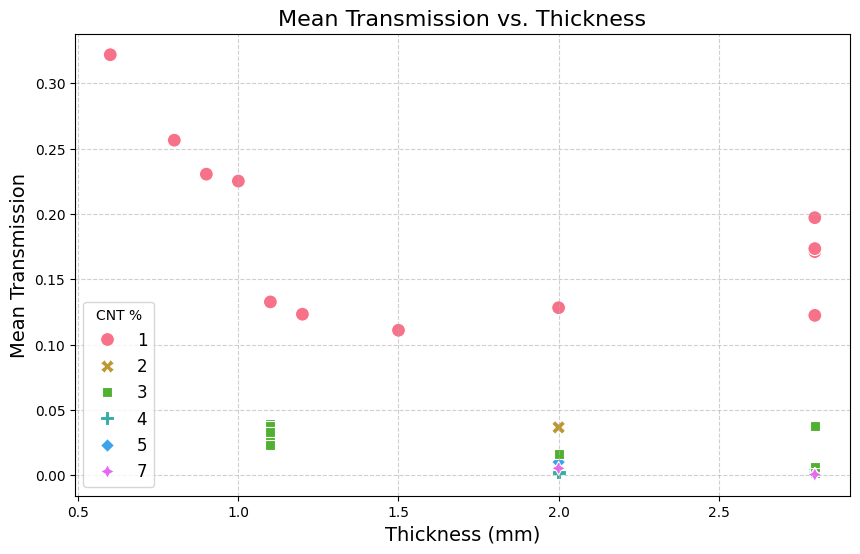

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_targets_by_thickness(df):
    """
    Plot mean absorption, reflection, and transmission as functions of thickness,
    with CNT% as different colors.

    Parameters:
    - df (pd.DataFrame): DataFrame containing 'thickness', 'cnt_pct', 'mean_a', 'mean_r', 'mean_t'
    """
    # Define target variables and titles
    targets = {'mean_a': 'Mean Absorption', 'mean_r': 'Mean Reflection', 'mean_t': 'Mean Transmission'}
    colors = sns.color_palette("husl", len(df['cnt_pct'].unique()))

    # Create separate plots for each target
    for target, title in targets.items():
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=df,
            x="thickness",
            y=target,
            hue="cnt_pct",
            palette=colors,
            style="cnt_pct",
            s=100
        )
        plt.title(f'{title} vs. Thickness', fontsize=16)
        plt.xlabel('Thickness (mm)', fontsize=14)
        plt.ylabel(title, fontsize=14)
        plt.legend(title='CNT %', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

# Call the function
plot_targets_by_thickness(thesis_df)


In [28]:
import re
from collections import defaultdict

def get_cnt_thickness_combinations(thesis_df):
    """
    Function to find unique CNT-Thickness combinations, count the number of files for each combination,
    and list the files belonging to each combination.

    Parameters:
    - thesis_df (pd.DataFrame): DataFrame containing thesis data, with a 'filename' column.

    Returns:
    - dict: Dictionary where keys are (CNT%, Thickness) tuples, and values are dictionaries with
            'count' and 'files'.
    """
    # Dictionary to store the results
    combinations = defaultdict(lambda: {"count": 0, "files": []})

    # Loop through each row in the DataFrame
    for _, row in thesis_df.iterrows():
        # Extract filename
        filename = row['filename']

        # Extract CNT% and Thickness using regex
        match = re.search(r'(\d+)%/(?:ABS|PBT)/\d+%-(?:ABS|PBT)-([\d.]+)mm', filename)
        if match:
            cnt_pct = int(match.group(1))
            thickness = float(match.group(2))

            # Create combination key
            combination_key = (cnt_pct, thickness)

            # Update dictionary
            combinations[combination_key]["count"] += 1
            combinations[combination_key]["files"].append(filename)

    return combinations




In [32]:
# Example usage
combinations = get_cnt_thickness_combinations(thesis_df)
for key, value in combinations.items():
    print(f"Combination CNT%={key[0]} Thickness={key[1]}mm: {value['count']} files")
    #print("Files:", value['files'])

Combination CNT%=4 Thickness=2.0mm: 1 files
Combination CNT%=5 Thickness=2.8mm: 5 files
Combination CNT%=5 Thickness=2.0mm: 1 files
Combination CNT%=3 Thickness=1.1mm: 6 files
Combination CNT%=3 Thickness=2.8mm: 5 files
Combination CNT%=3 Thickness=2.0mm: 1 files
Combination CNT%=1 Thickness=2.8mm: 5 files
Combination CNT%=1 Thickness=1.0mm: 1 files
Combination CNT%=1 Thickness=0.8mm: 1 files
Combination CNT%=1 Thickness=0.6mm: 1 files
Combination CNT%=1 Thickness=0.9mm: 1 files
Combination CNT%=1 Thickness=1.1mm: 1 files
Combination CNT%=1 Thickness=1.5mm: 1 files
Combination CNT%=1 Thickness=2.0mm: 1 files
Combination CNT%=1 Thickness=1.2mm: 1 files
Combination CNT%=7 Thickness=2.8mm: 3 files
Combination CNT%=7 Thickness=2.0mm: 1 files
Combination CNT%=2 Thickness=2.0mm: 1 files


In [31]:
combinations

defaultdict(<function __main__.get_cnt_thickness_combinations.<locals>.<lambda>()>,
            {(4, 2.0): {'count': 1, 'files': ['4%/PBT/4%-PBT-2.0mm.csv']},
             (5, 2.8): {'count': 5,
              'files': ['5%/PBT/5%-PBT-2.8mm-B.csv',
               '5%/PBT/5%-PBT-2.8mm-A.csv',
               '5%/ABS/5%-ABS-2.8mm-C.csv',
               '5%/ABS/5%-ABS-2.8mm-B.csv',
               '5%/ABS/5%-ABS-2.8mm-A.csv']},
             (5, 2.0): {'count': 1, 'files': ['5%/PBT/5%-PBT-2.0mm.csv']},
             (3, 1.1): {'count': 6,
              'files': ['3%/ABS/3%-ABS-1.1mm-B-ambient.csv',
               '3%/ABS/3%-ABS-1.1mm-A-ambient.csv',
               '3%/ABS/3%-ABS-1.1mm-A-compressed.csv',
               '3%/ABS/3%-ABS-1.1mm-B-compressed.csv',
               '3%/ABS/3%-ABS-1.1mm-B-quenched.csv',
               '3%/ABS/3%-ABS-1.1mm-A-quenched.csv']},
             (3, 2.8): {'count': 5,
              'files': ['3%/ABS/3%-ABS-2.8mm-C.csv',
               '3%/ABS/3%-ABS-2.8mm-B.csv',

In [33]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

def prepare_gpr_data(thesis_df):
    """
    Prepare data for GPR by grouping by CNT% and Thickness combinations,
    and aggregating the mean and variance of target values.
    """
    # Extract CNT% and Thickness from filenames
    thesis_df['CNT%'] = thesis_df['filename'].str.extract(r'(\d+)%').astype(float)
    thesis_df['Thickness'] = thesis_df['filename'].str.extract(r'([\d.]+)mm').astype(float)

    # Group by CNT% and Thickness, calculate mean and variance for targets
    aggregated = (
        thesis_df.groupby(['CNT%', 'Thickness'])
        .agg(
            mean_absorption=('mean_a', 'mean'),
            var_absorption=('mean_a', 'var'),
            mean_reflection=('mean_r', 'mean'),
            var_reflection=('mean_r', 'var'),
            mean_transmission=('mean_t', 'mean'),
            var_transmission=('mean_t', 'var')
        )
        .reset_index()
    )

    # Replace NaN variances with small values to avoid issues
    aggregated.fillna(1e-6, inplace=True)

    return aggregated

def train_gpr_model(aggregated, target_column, noise_column):
    """
    Train a GPR model on the aggregated data.

    Parameters:
    - aggregated (pd.DataFrame): Dataframe with aggregated features and targets.
    - target_column (str): Column name for the target variable.
    - noise_column (str): Column name for the noise (variance) variable.

    Returns:
    - gpr (GaussianProcessRegressor): Trained GPR model.
    """
    # Input features (CNT%, Thickness)
    X = aggregated[['CNT%', 'Thickness']].values

    # Target variable (e.g., Absorption)
    y = aggregated[target_column].values

    # Noise (variance of the target)
    noise = aggregated[noise_column].values

    # Define the kernel: RBF kernel + WhiteKernel for noise
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1.0)

    # Create and fit the GPR model
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=noise, n_restarts_optimizer=10, random_state=42)
    gpr.fit(X, y)

    return gpr

def predict_gpr(gpr, X_new):
    """
    Predict using the trained GPR model.

    Parameters:
    - gpr (GaussianProcessRegressor): Trained GPR model.
    - X_new (np.ndarray): New input features for prediction.

    Returns:
    - y_pred (np.ndarray): Predicted mean values.
    - y_std (np.ndarray): Predicted standard deviations (uncertainty).
    """
    y_pred, y_std = gpr.predict(X_new, return_std=True)
    return y_pred, y_std

# Example usage:
# Prepare the data
aggregated_data = prepare_gpr_data(thesis_df)

# Train GPR models for each target
gpr_absorption = train_gpr_model(aggregated_data, 'mean_absorption', 'var_absorption')
gpr_reflection = train_gpr_model(aggregated_data, 'mean_reflection', 'var_reflection')
gpr_transmission = train_gpr_model(aggregated_data, 'mean_transmission', 'var_transmission')

# Predict for new data (example input)
X_new = np.array([[3, 2.8], [5, 1.1]])  # Example CNT% and Thickness combinations
absorption_pred, absorption_std = predict_gpr(gpr_absorption, X_new)
reflection_pred, reflection_std = predict_gpr(gpr_reflection, X_new)
transmission_pred, transmission_std = predict_gpr(gpr_transmission, X_new)

print("Predictions for Absorption:", absorption_pred)
print("Uncertainty for Absorption:", absorption_std)
print("Predictions for Reflection:", reflection_pred)
print("Uncertainty for Reflection:", reflection_std)
print("Predictions for Transmission:", transmission_pred)
print("Uncertainty for Transmission:", transmission_std)


Predictions for Absorption: [0.37459004 0.27695138]
Uncertainty for Absorption: [0.05557343 0.05742515]
Predictions for Reflection: [0.60789926 0.69519531]
Uncertainty for Reflection: [0.09126449 0.09666707]
Predictions for Transmission: [0.010163   0.00619542]
Uncertainty for Transmission: [0.0355633 0.0948324]


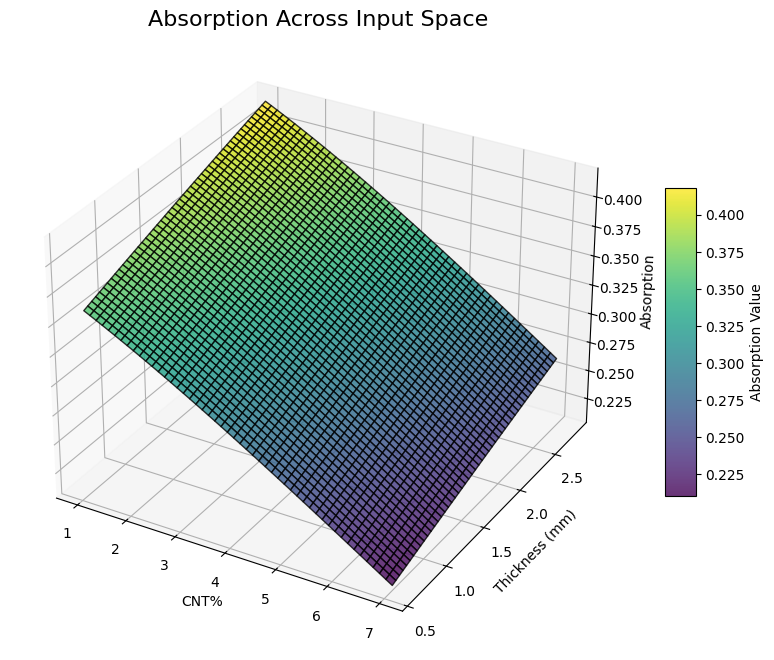

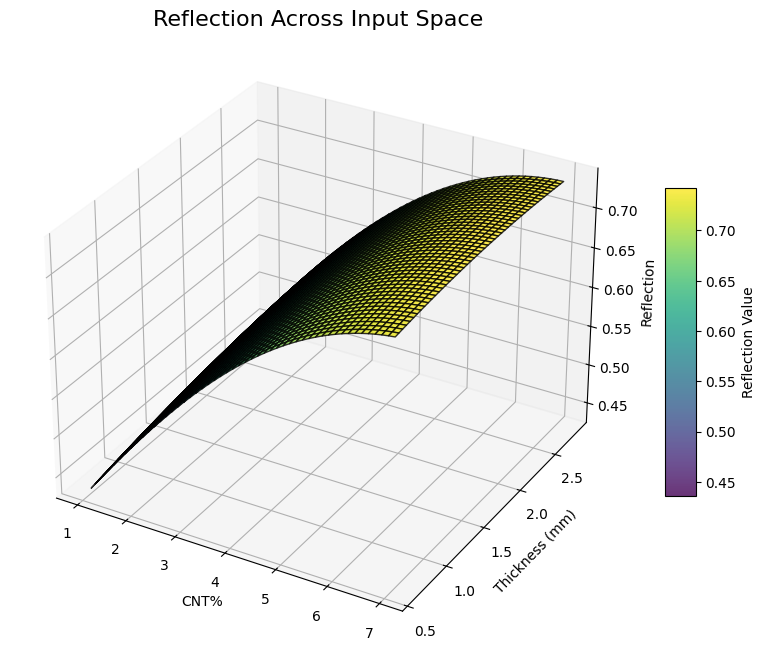

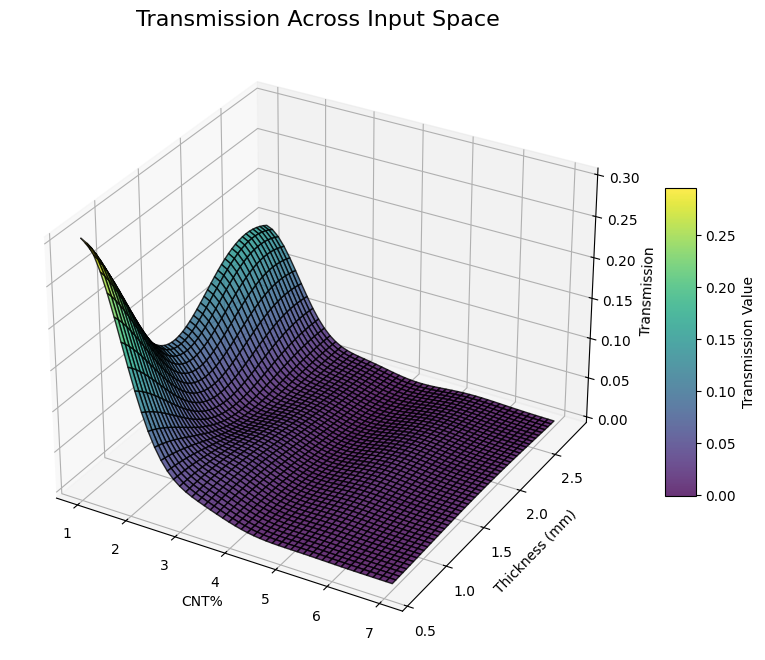

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_target_surface(gpr, title, X, Y, target_name):
    """
    Visualize the target variable as a 3D surface plot.

    Parameters:
    - gpr (GaussianProcessRegressor): Trained GPR model for the target.
    - title (str): Title for the plot.
    - X (np.ndarray): 2D array of CNT% values for the grid.
    - Y (np.ndarray): 2D array of Thickness values for the grid.
    - target_name (str): Name of the target variable being visualized.
    """
    # Create a meshgrid for CNT% and Thickness
    X_flat = X.ravel()
    Y_flat = Y.ravel()
    grid_points = np.vstack([X_flat, Y_flat]).T

    # Predict values for the grid
    Z_pred, Z_std = gpr.predict(grid_points, return_std=True)
    Z_pred = Z_pred.reshape(X.shape)

    # Plot the surface
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(X, Y, Z_pred, cmap='viridis', alpha=0.8, edgecolor='k')

    # Add color bar and labels
    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10, label=f"{target_name} Value")
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("CNT%")
    ax.set_ylabel("Thickness (mm)")
    ax.set_zlabel(target_name)
    plt.show()

# Generate a grid of CNT% and Thickness
cnt_values = np.linspace(thesis_df['CNT%'].min(), thesis_df['CNT%'].max(), 50)
thickness_values = np.linspace(thesis_df['Thickness'].min(), thesis_df['Thickness'].max(), 50)
CNT_grid, Thickness_grid = np.meshgrid(cnt_values, thickness_values)

# Visualize each target variable
visualize_target_surface(gpr_absorption, "Absorption Across Input Space", CNT_grid, Thickness_grid, "Absorption")
visualize_target_surface(gpr_reflection, "Reflection Across Input Space", CNT_grid, Thickness_grid, "Reflection")
visualize_target_surface(gpr_transmission, "Transmission Across Input Space", CNT_grid, Thickness_grid, "Transmission")


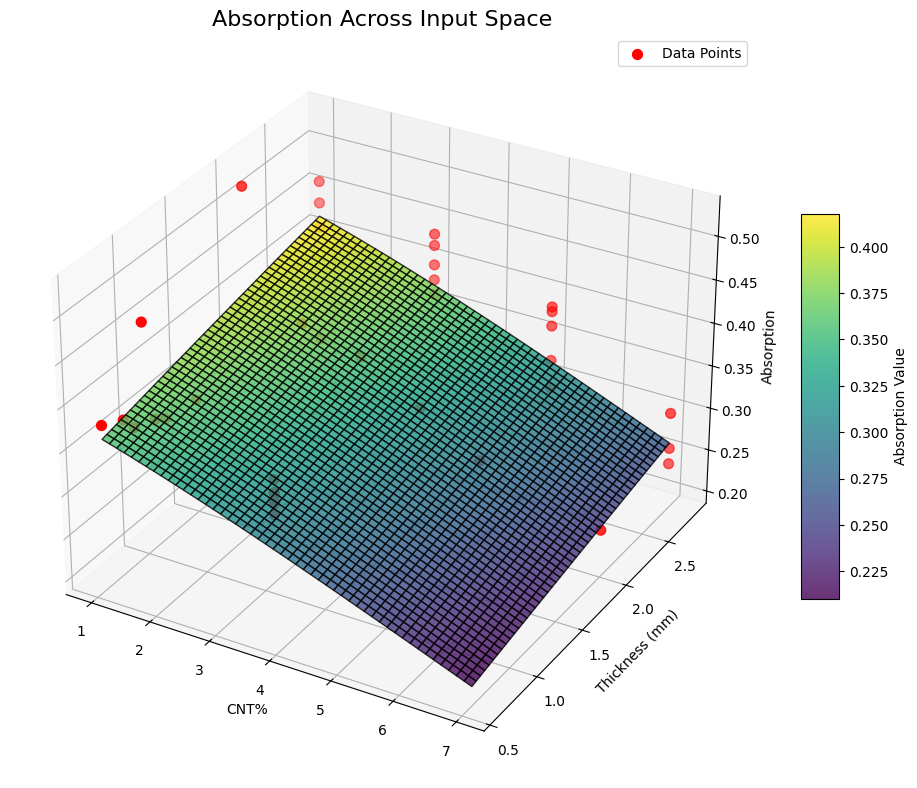

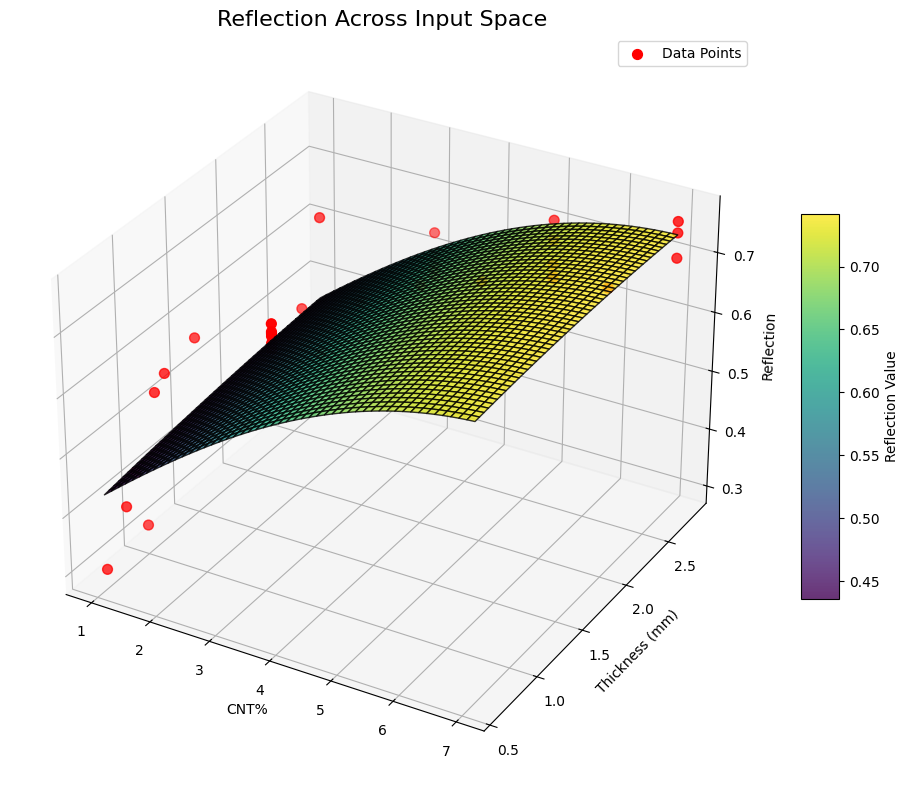

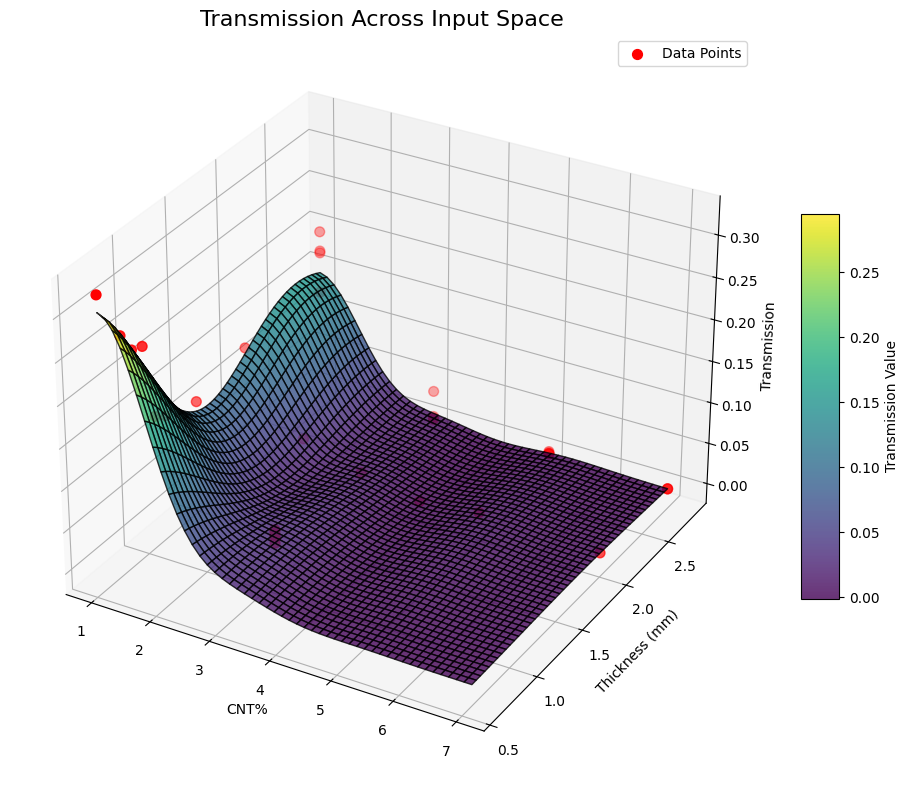

In [36]:
def visualize_target_surface_with_points(gpr, title, X, Y, target_name, thesis_df, target_col, x_col="CNT%", y_col="Thickness"):
    """
    Visualize the target variable as a 3D surface plot with data points overlayed.

    Parameters:
    - gpr (GaussianProcessRegressor): Trained GPR model for the target.
    - title (str): Title for the plot.
    - X (np.ndarray): 2D array of CNT% values for the grid.
    - Y (np.ndarray): 2D array of Thickness values for the grid.
    - target_name (str): Name of the target variable being visualized.
    - thesis_df (pd.DataFrame): DataFrame containing the original data points.
    - target_col (str): Column name for the target variable in the DataFrame.
    - x_col (str): Column name for the x-axis variable (CNT%).
    - y_col (str): Column name for the y-axis variable (Thickness).
    """
    # Create a meshgrid for CNT% and Thickness
    X_flat = X.ravel()
    Y_flat = Y.ravel()
    grid_points = np.vstack([X_flat, Y_flat]).T

    # Predict values for the grid
    Z_pred, Z_std = gpr.predict(grid_points, return_std=True)
    Z_pred = Z_pred.reshape(X.shape)

    # Plot the surface
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    surface = ax.plot_surface(X, Y, Z_pred, cmap='viridis', alpha=0.8, edgecolor='k')

    # Add the actual data points as scatter points
    ax.scatter(thesis_df[x_col], thesis_df[y_col], thesis_df[target_col], color='r', s=50, label="Data Points")

    # Add color bar and labels
    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10, label=f"{target_name} Value")
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("CNT%")
    ax.set_ylabel("Thickness (mm)")
    ax.set_zlabel(target_name)
    ax.legend()
    plt.show()

# Visualize with the actual data points overlayed
visualize_target_surface_with_points(
    gpr_absorption, "Absorption Across Input Space", CNT_grid, Thickness_grid,
    "Absorption", thesis_df, "mean_a", "CNT%", "Thickness"
)

visualize_target_surface_with_points(
    gpr_reflection, "Reflection Across Input Space", CNT_grid, Thickness_grid,
    "Reflection", thesis_df, "mean_r", "CNT%", "Thickness"
)

visualize_target_surface_with_points(
    gpr_transmission, "Transmission Across Input Space", CNT_grid, Thickness_grid,
    "Transmission", thesis_df, "mean_t", "CNT%", "Thickness"
)


Removing white noise smoothing function

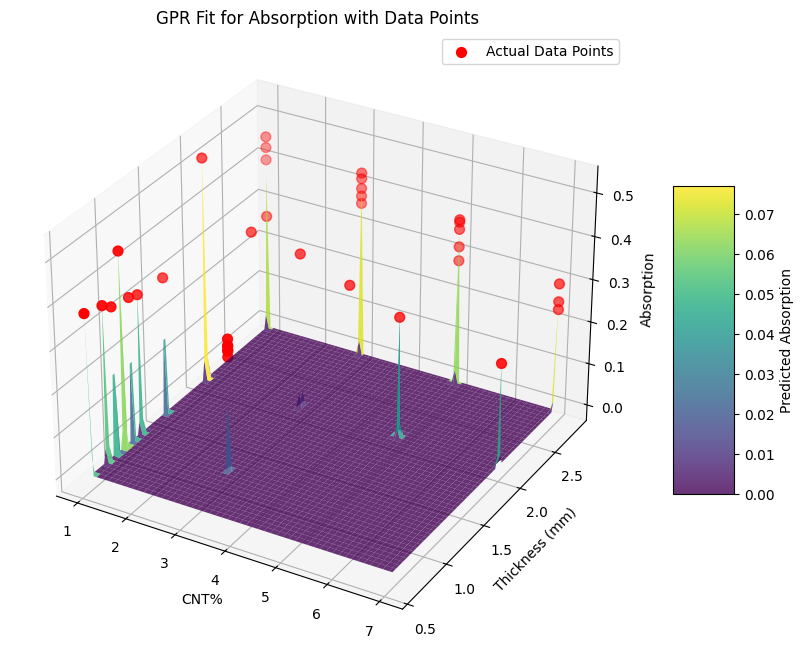

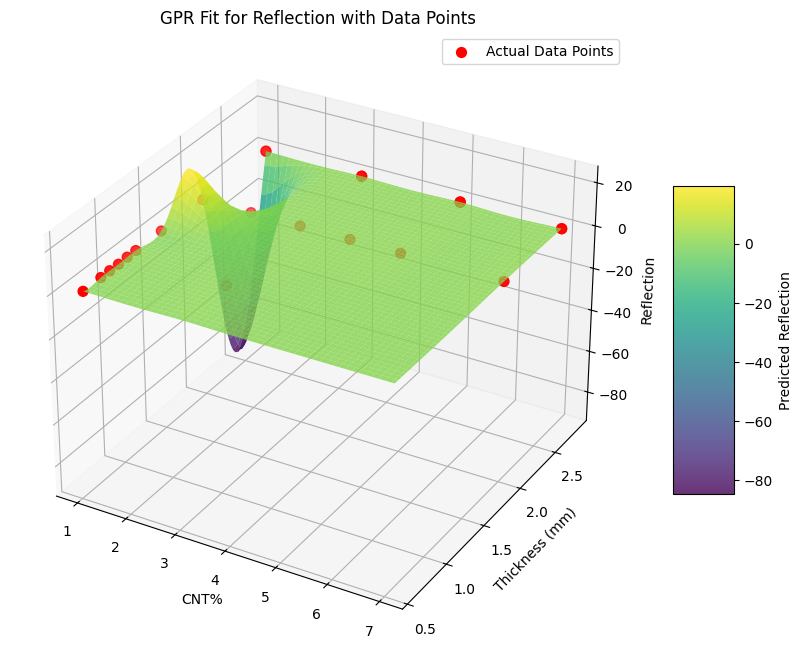

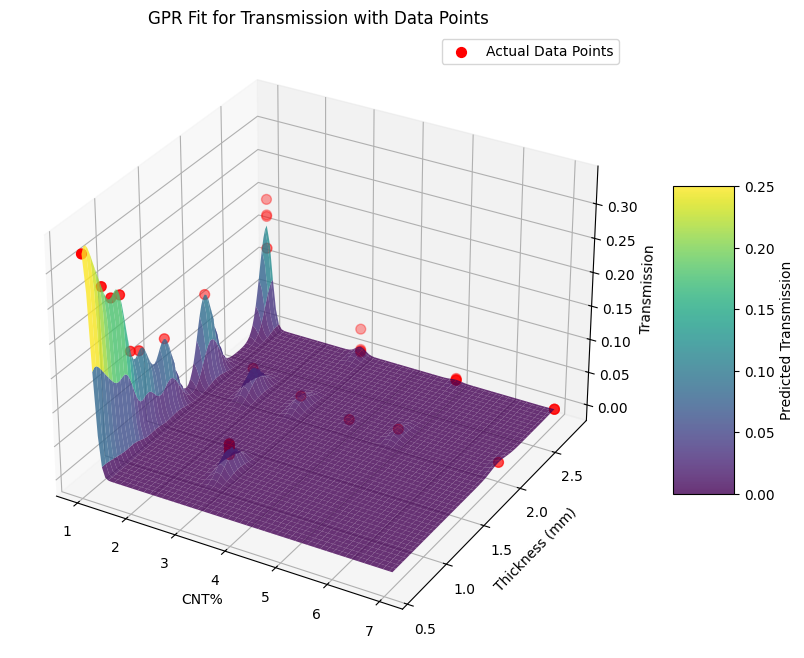

In [43]:
def create_train_visualize_gpr_custom(thesis_df, target, grid_resolution=100):
    """
    Train a GPR model with target-specific kernel configurations and visualize the fit.

    Parameters:
    - thesis_df (pd.DataFrame): The dataset containing input features and targets.
    - target (str): The target variable to predict ('absorption', 'reflection', or 'transmission').
    - grid_resolution (int): Resolution for the prediction grid.

    Returns:
    - gpr_model (GaussianProcessRegressor): Trained GPR model.
    """
    # Extract features and target from thesis_df
    X = thesis_df[['CNT%', 'Thickness']].values
    y = thesis_df[f'mean_{target[0].lower()}'].values  # mean_a, mean_r, or mean_t

    # Define custom kernel configurations based on the target variable
    if target == "absorption":
        kernel = C(1.0, (1e-1, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e1))
    elif target in ["reflection", "transmission"]:
        kernel = C(1.0, (1e-2, 1e3)) * RBF(length_scale=2.0, length_scale_bounds=(1e-1, 1e2))
    else:
        raise ValueError(f"Unknown target: {target}. Choose from 'absorption', 'reflection', or 'transmission'.")

    # Train the Gaussian Process Regressor
    gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=10)
    gpr_model.fit(X, y)

    # Generate grid for predictions
    CNT_grid = np.linspace(thesis_df['CNT%'].min(), thesis_df['CNT%'].max(), grid_resolution)
    Thickness_grid = np.linspace(thesis_df['Thickness'].min(), thesis_df['Thickness'].max(), grid_resolution)
    CNT_grid, Thickness_grid = np.meshgrid(CNT_grid, Thickness_grid)
    X_pred = np.c_[CNT_grid.ravel(), Thickness_grid.ravel()]

    # Make predictions
    y_pred, y_std = gpr_model.predict(X_pred, return_std=True)
    y_pred = y_pred.reshape(CNT_grid.shape)

    # Plot the surface and overlay data points
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(CNT_grid, Thickness_grid, y_pred, cmap='viridis', alpha=0.8)
    fig.colorbar(surf, shrink=0.5, aspect=5, label=f'Predicted {target.capitalize()}')

    # Overlay the actual data points
    ax.scatter(
        thesis_df['CNT%'], thesis_df['Thickness'], thesis_df[f'mean_{target[0].lower()}'],
        c='red', label='Actual Data Points', s=50
    )

    # Labels and title
    ax.set_xlabel('CNT%')
    ax.set_ylabel('Thickness (mm)')
    ax.set_zlabel(f'{target.capitalize()}')
    ax.set_title(f'GPR Fit for {target.capitalize()} with Data Points')
    ax.legend()
    plt.show()

    return gpr_model

# Example usage for each target:
gpr_model_absorption = create_train_visualize_gpr_custom(thesis_df, target="absorption")
gpr_model_reflection = create_train_visualize_gpr_custom(thesis_df, target="reflection")
gpr_model_transmission = create_train_visualize_gpr_custom(thesis_df, target="transmission")


In [44]:
thesis_df

filename  cnt_pct material  thickness  \
0                4%/PBT/4%-PBT-2.0mm.csv        4      PBT        2.0   
1              5%/PBT/5%-PBT-2.8mm-B.csv        5      PBT        2.8   
2                5%/PBT/5%-PBT-2.0mm.csv        5      PBT        2.0   
3              5%/PBT/5%-PBT-2.8mm-A.csv        5      PBT        2.8   
4              5%/ABS/5%-ABS-2.8mm-C.csv        5      ABS        2.8   
5              5%/ABS/5%-ABS-2.8mm-B.csv        5      ABS        2.8   
6              5%/ABS/5%-ABS-2.8mm-A.csv        5      ABS        2.8   
7      3%/ABS/3%-ABS-1.1mm-B-ambient.csv        3      ABS        1.1   
8              3%/ABS/3%-ABS-2.8mm-C.csv        3      ABS        2.8   
9      3%/ABS/3%-ABS-1.1mm-A-ambient.csv        3      ABS        1.1   
10  3%/ABS/3%-ABS-1.1mm-A-compressed.csv        3      ABS        1.1   
11  3%/ABS/3%-ABS-1.1mm-B-compressed.csv        3      ABS        1.1   
12             3%/ABS/3%-ABS-2.8mm-B.csv        3      ABS        2.8   
13    3%/ABS/3%-ABS-1.1mm-B-quenched.csv        3      ABS        1.1   
14             3%/ABS/3%-ABS-2.8mm-A.csv        3      ABS        2.8   
15    3%/ABS/3%-ABS-1.1mm-A-quenched.csv        3      ABS        1.1   
16             3%/PBT/3%-PBT-2.8mm-A.csv        3      PBT        2.8   
17             3%/PBT/3%-PBT-2.8mm-B.csv        3      PBT        2.8   
18               3%/PBT/3%-PBT-2.0mm.csv        3      PBT        2.0   
19             1%/ABS/1%-ABS-2.8mm-C.csv        1      ABS        2.8   
20             1%/ABS/1%-ABS-2.8mm-A.csv        1      ABS        2.8   
21             1%/ABS/1%-ABS-2.8mm-B.csv        1      ABS        2.8   
22               1%/PBT/1%-PBT-1.0mm.csv        1      PBT        1.0   
23               1%/PBT/1%-PBT-0.8mm.csv        1      PBT        0.8   
24               1%/PBT/1%-PBT-0.6mm.csv        1      PBT        0.6   
25               1%/PBT/1%-PBT-0.9mm.csv        1      PBT        0.9   
26               1%/PBT/1%-PBT-1.1mm.csv        1      PBT        1.1   
27               1%/PBT/1%-PBT-1.5mm.csv        1      PBT        1.5   
28               1%/PBT/1%-PBT-2.0mm.csv        1      PBT        2.0   
29               1%/PBT/1%-PBT-1.2mm.csv        1      PBT        1.2   
30             1%/PBT/1%-PBT-2.8mm-A.csv        1      PBT        2.8   
31             1%/PBT/1%-PBT-2.8mm-B.csv        1      PBT        2.8   
32             7%/PBT/7%-PBT-2.8mm-C.csv        7      PBT        2.8   
33               7%/PBT/7%-PBT-2.0mm.csv        7      PBT        2.0   
34             7%/PBT/7%-PBT-2.8mm-A.csv        7      PBT        2.8   
35             7%/PBT/7%-PBT-2.8mm-B.csv        7      PBT        2.8   
36               2%/PBT/2%-PBT-2.0mm.csv        2      PBT        2.0   

      mean_a     max_a     std_a   range_a  weighted_mean_a    mean_r  ...  \
0   0.322400  0.366000  0.032448  0.120000         0.325429  0.675710  ...   
1   0.290490  0.340000  0.031941  0.109000         0.293846  0.708940  ...   
2   0.280870  0.308000  0.024239  0.087000         0.282945  0.709060  ...   
3   0.381270  0.428000  0.032487  0.121000         0.384122  0.614710  ...   
4   0.323394  0.378991  0.037225  0.151901         0.327121  0.675066  ...   
5   0.386848  0.447619  0.041150  0.165001         0.391030  0.610900  ...   
6   0.364283  0.420302  0.037661  0.154790         0.368035  0.634600  ...   
7   0.277968  0.336482  0.037138  0.145670         0.281689  0.682892  ...   
8   0.398753  0.453739  0.037528  0.153152         0.402528  0.597885  ...   
9   0.264837  0.319390  0.035780  0.132930         0.268387  0.703096  ...   
10  0.281274  0.338221  0.039644  0.144775         0.285284  0.690035  ...   
11  0.290129  0.353294  0.042431  0.157088         0.294446  0.687087  ...   
12  0.435038  0.490228  0.038678  0.156334         0.438938  0.560936  ...   
13  0.290931  0.344721  0.035428  0.132914         0.294494  0.671609  ...   
14  0.421625  0.481314  0.041075  0.164893         0.425800  0.572293  ...   
15  0.305

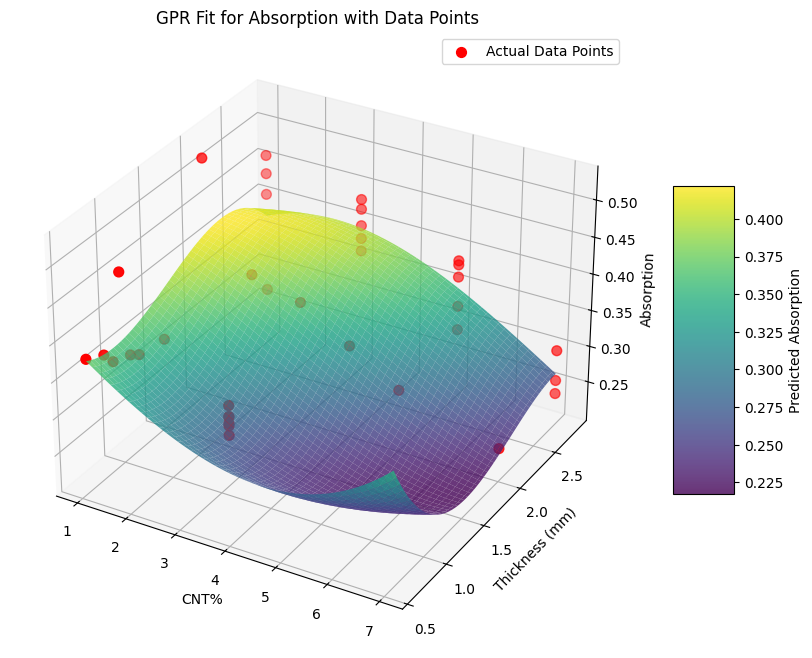

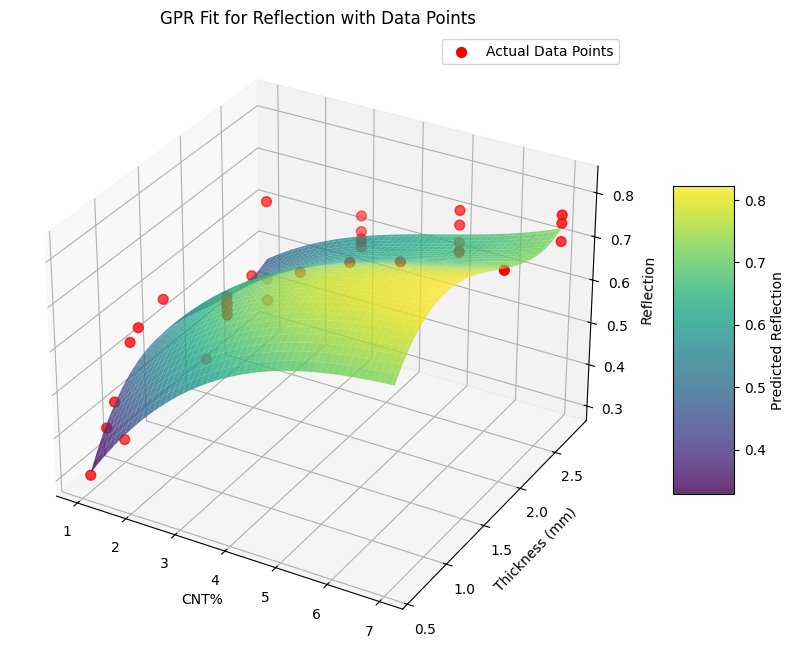

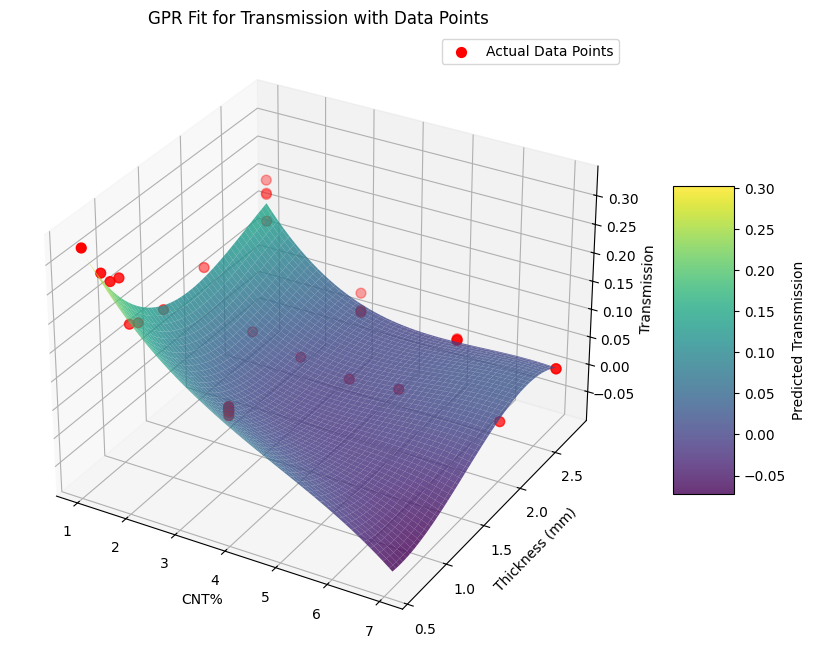

In [52]:
from sklearn.preprocessing import MinMaxScaler

def create_train_visualize_gpr_custom_normalized(thesis_df, target, grid_resolution=100):
    """
    Train a GPR model with target-specific kernel configurations and visualize the fit,
    with normalization of input features.

    Parameters:
    - thesis_df (pd.DataFrame): The dataset containing input features and targets.
    - target (str): The target variable to predict ('absorption', 'reflection', or 'transmission').
    - grid_resolution (int): Resolution for the prediction grid.

    Returns:
    - gpr_model (GaussianProcessRegressor): Trained GPR model.
    """
    # Extract features and target from thesis_df
    features = thesis_df[['CNT%', 'Thickness']].values
    targets = thesis_df[f'mean_{target[0].lower()}'].values

    # Normalize the features
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    # Define custom kernel configurations based on the target variable
    if target == "absorption":
        kernel = C(1.0, (1e-1, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e1, 1e3))
    elif target in ["reflection", "transmission"]:
        kernel = C(1.0, (1e-2, 1e3)) * RBF(length_scale=2.0, length_scale_bounds=(1e1, 1e3))
    else:
        raise ValueError(f"Unknown target: {target}. Choose from 'absorption', 'reflection', or 'transmission'.")

    # Train the Gaussian Process Regressor
    gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, n_restarts_optimizer=10)
    gpr_model.fit(features_scaled, targets)

    # Generate grid for predictions
    CNT_grid = np.linspace(thesis_df['CNT%'].min(), thesis_df['CNT%'].max(), grid_resolution)
    Thickness_grid = np.linspace(thesis_df['Thickness'].min(), thesis_df['Thickness'].max(), grid_resolution)
    CNT_grid, Thickness_grid = np.meshgrid(CNT_grid, Thickness_grid)
    X_pred = np.c_[CNT_grid.ravel(), Thickness_grid.ravel()]
    X_pred_scaled = scaler.transform(X_pred)

    # Make predictions
    y_pred, y_std = gpr_model.predict(X_pred_scaled, return_std=True)
    y_pred = y_pred.reshape(CNT_grid.shape)

    # Plot the surface and overlay data points
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(CNT_grid, Thickness_grid, y_pred, cmap='viridis', alpha=0.8)
    fig.colorbar(surf, shrink=0.5, aspect=5, label=f'Predicted {target.capitalize()}')

    # Overlay the actual data points
    ax.scatter(
        thesis_df['CNT%'], thesis_df['Thickness'], thesis_df[f'mean_{target[0].lower()}'],
        c='red', label='Actual Data Points', s=50
    )

    # Labels and title
    ax.set_xlabel('CNT%')
    ax.set_ylabel('Thickness (mm)')
    ax.set_zlabel(f'{target.capitalize()}')
    ax.set_title(f'GPR Fit for {target.capitalize()} with Data Points')
    ax.legend()
    plt.show()

    return gpr_model

# Example usage for each target:
gpr_model_absorption = create_train_visualize_gpr_custom_normalized(thesis_df, target="absorption")
gpr_model_reflection = create_train_visualize_gpr_custom_normalized(thesis_df, target="reflection")
gpr_model_transmission = create_train_visualize_gpr_custom_normalized(thesis_df, target="transmission")


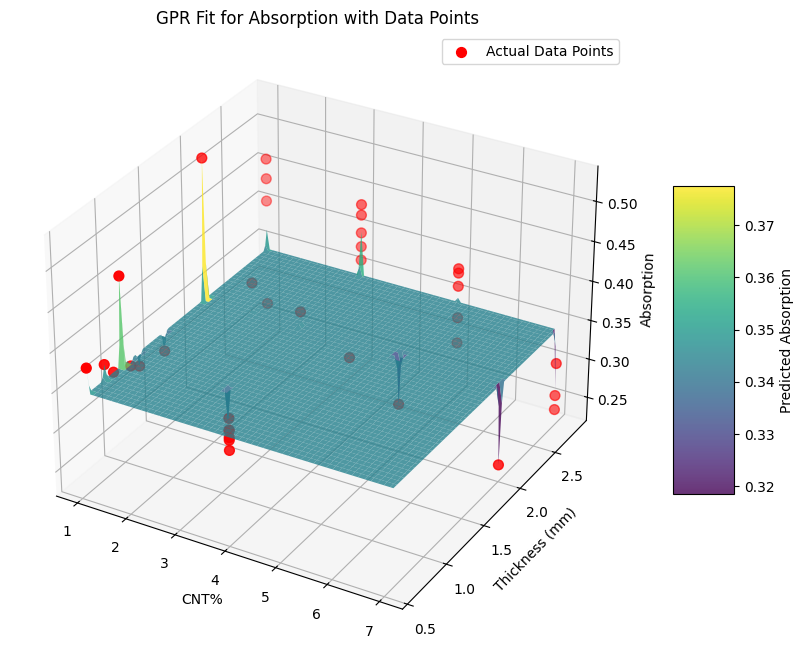

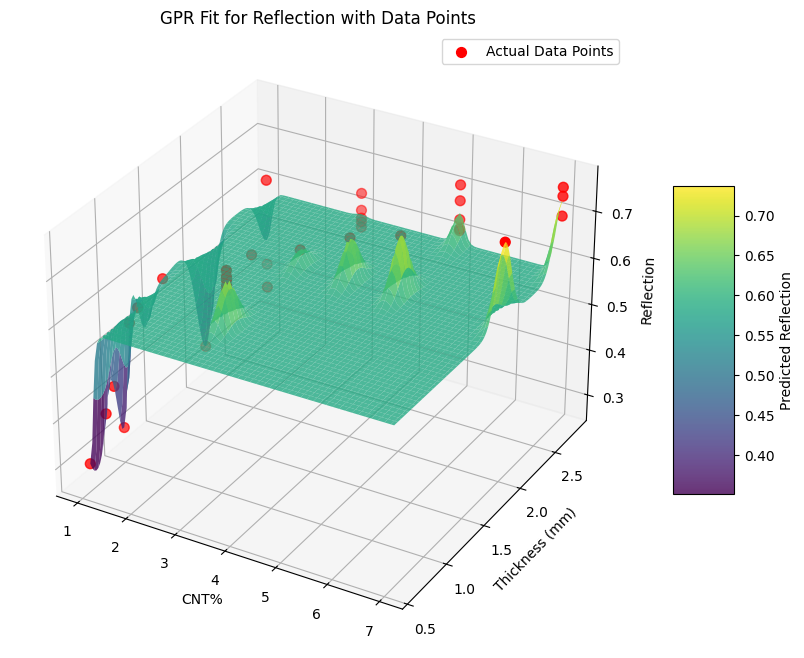

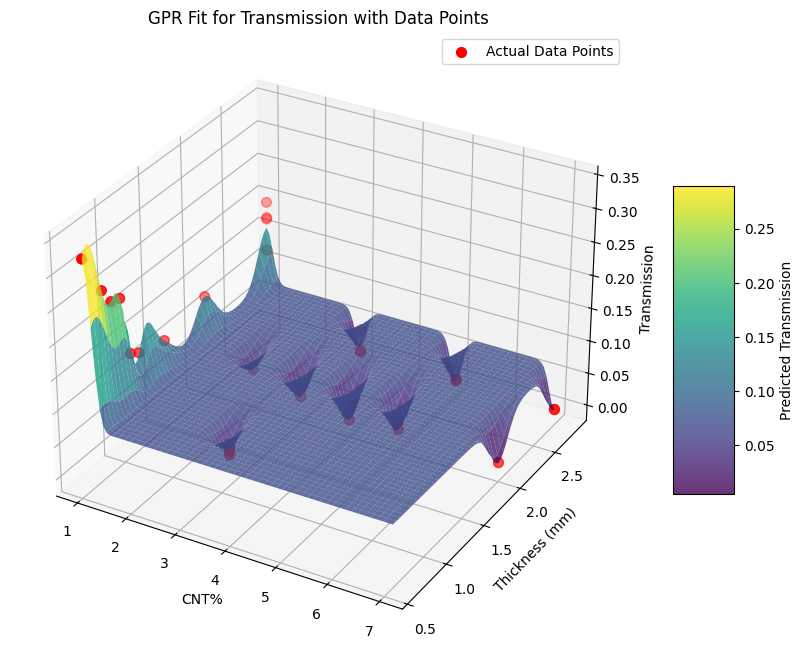

In [47]:
# def create_train_visualize_gpr_custom_debug(thesis_df, target, grid_resolution=100):
#     """
#     Train a GPR model with target-specific kernel configurations, visualize the fit,
#     and debug prediction anomalies.

#     Parameters:
#     - thesis_df (pd.DataFrame): The dataset containing input features and targets.
#     - target (str): The target variable to predict ('absorption', 'reflection', or 'transmission').
#     - grid_resolution (int): Resolution for the prediction grid.

#     Returns:
#     - gpr_model (GaussianProcessRegressor): Trained GPR model.
#     """
#     # Extract features and target from thesis_df
#     X = thesis_df[['CNT%', 'Thickness']].values
#     y = thesis_df[f'mean_{target[0].lower()}'].values

#     # Normalize target values
#     y_mean, y_std_dev = y.mean(), y.std()
#     y_normalized = (y - y_mean) / y_std_dev

#     # Define custom kernel configurations
#     if target == "absorption":
#         kernel = C(1.0, (1e-1, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e1))
#     elif target in ["reflection", "transmission"]:
#         kernel = C(1.0, (1e-2, 1e3)) * RBF(length_scale=2.0, length_scale_bounds=(1e-1, 1e2))
#     else:
#         raise ValueError(f"Unknown target: {target}. Choose from 'absorption', 'reflection', or 'transmission'.")

#     # Train the Gaussian Process Regressor
#     gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=10)
#     gpr_model.fit(X, y_normalized)

#     # Generate grid for predictions
#     CNT_grid = np.linspace(thesis_df['CNT%'].min(), thesis_df['CNT%'].max(), grid_resolution)
#     Thickness_grid = np.linspace(thesis_df['Thickness'].min(), thesis_df['Thickness'].max(), grid_resolution)
#     CNT_grid, Thickness_grid = np.meshgrid(CNT_grid, Thickness_grid)
#     X_pred = np.c_[CNT_grid.ravel(), Thickness_grid.ravel()]

#     # Make predictions
#     y_pred_normalized, y_std = gpr_model.predict(X_pred, return_std=True)
#     y_pred = y_pred_normalized * y_std_dev + y_mean  # De-normalize predictions
#     y_pred = y_pred.reshape(CNT_grid.shape)

#     # Debugging: Print anomalies in predictions
#     if np.any(y_pred < -1) or np.any(y_pred > 1):
#         print(f"Anomalies in {target.capitalize()} Predictions:")
#         print(f"Min Prediction: {y_pred.min()}, Max Prediction: {y_pred.max()}")

#     # Clip predictions to a realistic range
#     y_pred = np.clip(y_pred, 0, 1)

#     # Plot the surface and overlay data points
#     fig = plt.figure(figsize=(12, 8))
#     ax = fig.add_subplot(111, projection='3d')
#     surf = ax.plot_surface(CNT_grid, Thickness_grid, y_pred, cmap='viridis', alpha=0.8)
#     fig.colorbar(surf, shrink=0.5, aspect=5, label=f'Predicted {target.capitalize()}')

#     # Overlay the actual data points
#     ax.scatter(
#         thesis_df['CNT%'], thesis_df['Thickness'], thesis_df[f'mean_{target[0].lower()}'],
#         c='red', label='Actual Data Points', s=50
#     )

#     # Labels and title
#     ax.set_xlabel('CNT%')
#     ax.set_ylabel('Thickness (mm)')
#     ax.set_zlabel(f'{target.capitalize()}')
#     ax.set_title(f'GPR Fit for {target.capitalize()} with Data Points')
#     ax.legend()
#     plt.show()

#     return gpr_model

# # Example usage for each target:
# gpr_model_absorption = create_train_visualize_gpr_custom_debug(thesis_df, target="absorption")
# gpr_model_reflection = create_train_visualize_gpr_custom_debug(thesis_df, target="reflection")
# gpr_model_transmission = create_train_visualize_gpr_custom_debug(thesis_df, target="transmission")
